In [1]:
# Run Spark 

from graphframes.examples import Graphs
import pyspark as ps
ps.SparkContext.setSystemProperty('spark.executor.memory', '60g')
ps.SparkContext.setSystemProperty('spark.dynamicAllocation.maxExecutor', '1')
ps.SparkContext.setSystemProperty("spark.executor.cores","1")
try:
    sc.stop()
except NameError:
    pass
conf = ps.SparkConf().setMaster('local')
sc = ps.SparkContext(conf=conf)
sqlContext = ps.SQLContext(sc)

In [15]:
# Run toy sample

from time import time

start = time()
# Create a Vertex DataFrame with unique ID column "id"
v = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)
print("Time to create graph: ", time()-start)

start = time()
# Query: Get in-degree of each vertex.
g.inDegrees.show()
print("Time to get in-degree of each vertex: ", time()-start)

start = time()
# Query: Count the number of "follow" connections in the graph.
follow_count = g.edges.filter("relationship = 'follow'").count()
print("The number of \"follow\" connections in the graph: ", follow_count)
print("Time to count: ", time()-start)

start = time()
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()
print("Time to run PageRank: ", time()-start)

Time to create graph:  4.0707314014434814
+---+--------+
| id|inDegree|
+---+--------+
|  c|       1|
|  b|       2|
+---+--------+

Time to get in-degree of each vertex:  5.64206075668335
The number of "follow" connections in the graph:  2
Time to count:  0.964646577835083
+---+------------------+
| id|          pagerank|
+---+------------------+
|  b|1.0905890109440908|
|  a|              0.01|
|  c|1.8994109890559092|
+---+------------------+

Time to run PageRank:  1740.9485974311829


In [1]:
# Download data

import pandas as pd

en_lda = pd.read_csv('Results/en_data_lda.csv', index_col=None)
et_lda = pd.read_csv('Results/et_data_lda.csv', index_col=None)

In [2]:
def clean_df(df, cols):
    for i in df.columns:
        if 'Unnamed' in i:
            del df[i]
    df = df[~pd.isnull(df['Nouns'])]
    for i in cols:
        del df[i]
    return df

en_lda = clean_df(en_lda, ['text_join', 'Tokens', 'Topic_bow', 'Topic_tfidf'])
et_lda = clean_df(et_lda, ['text_join', 'Tokens', 'Topic_bow', 'Topic_tfidf'])

In [3]:
def rewrite_est(w):
    w = w.lower()
    w = w.replace('ue', 'ä')
    w = w.replace('ufc', 'ü')
    w = w.replace('kuflakaas', 'külakaas')
    w = w.replace('mufufdud', 'müüdud')
    w = w.replace('uf', 'õ')
    w = w.replace('eestua', 'eesti') 
    w = w.replace('kohetule', 'kohe')
    return w

et_lda['Nouns'] = et_lda['Nouns'].apply(rewrite_est)
en_lda['Nouns'] = en_lda['Nouns'].apply(rewrite_est)

In [490]:
en_lda.head()

,link,node,Nouns,Topic_bow_index,Topic_tfidf_index
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,akrüülvärv stroke phthalo green ml,6,0
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,winter rod akara legend,18,44
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,digital pressure sensor bmp,36,35
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,converter bit ads,2,24
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,power charger va,0,1


In [228]:
# Choose small cluster

def investigate_clusters(data, col):
    count_clusters = {}
    for cluster in list(set(data[col])):
        df = data[data[col] == cluster]
        count_clusters[cluster] = (len(df), len(set(df.link)))
    return count_clusters

# BOW
clusters_en_lda_bow = investigate_clusters(en_lda, 'Topic_bow_index')
all_c = []
for i in range(len(clusters_en_lda_bow)):
    all_c.append(clusters_en_lda_bow[i][0])
print("Min number of products: ", min(all_c))

Min number of products:  1225


In [23]:
clusters_en_lda_bow
# In cluster 44

{0: (33450, 13111),
 1: (2125, 993),
 2: (2985, 1430),
 3: (2616, 1463),
 4: (3413, 1848),
 5: (6105, 2047),
 6: (2523, 1557),
 7: (4372, 1729),
 8: (1577, 754),
 9: (4503, 1726),
 10: (3033, 1342),
 11: (2428, 982),
 12: (2934, 1012),
 13: (3614, 2014),
 14: (2443, 1220),
 15: (3399, 1860),
 16: (1648, 648),
 17: (2764, 1786),
 18: (2250, 1160),
 19: (3364, 1101),
 20: (2633, 1626),
 21: (1864, 825),
 22: (1360, 738),
 23: (3539, 1456),
 24: (2889, 1956),
 25: (2699, 1446),
 26: (2215, 1258),
 27: (2113, 1078),
 28: (2444, 1181),
 29: (3590, 1139),
 30: (4644, 1851),
 31: (2576, 1327),
 32: (1871, 1046),
 33: (2748, 1261),
 34: (2149, 1205),
 35: (4527, 2082),
 36: (2490, 1144),
 37: (2076, 1556),
 38: (2610, 1387),
 39: (2843, 1089),
 40: (1656, 643),
 41: (3862, 1587),
 42: (2568, 991),
 43: (1641, 863),
 44: (1225, 621),
 45: (2932, 1230),
 46: (1645, 973),
 47: (1810, 748),
 48: (2411, 1397),
 49: (11204, 1457),
 50: (2503, 1550),
 51: (1891, 1212),
 52: (1954, 1342),
 53: (3683, 

In [229]:
comp = []
for c in en_lda.link[en_lda.Topic_bow_index == 44]:
    i_list = c.split('/')
    i = i_list[0].replace('https', '').replace('http', '').replace(':', '').replace('<', '')
    comp.append(i)
companies = list(set(comp))
print("Number of companies in 44th EN bow cluster with ", min(all_c), ' products: ', len(companies))

Number of companies in 44th EN bow cluster with  1225  products:  104


In [231]:
#TF IDF
clusters_en_lda_tfidf = investigate_clusters(en_lda, 'Topic_tfidf_index')
all_c = []
for i in range(len(clusters_en_lda_tfidf)):
    all_c.append(clusters_en_lda_tfidf[i][0])
print("Min number of products: ", min(all_c))

Min number of products:  1545


In [226]:
clusters_en_lda_tfidf
# In cluster 31

{0: (30922, 12929),
 1: (2131, 1070),
 2: (1689, 1016),
 3: (2287, 926),
 4: (2352, 865),
 5: (2523, 1382),
 6: (2900, 2207),
 7: (2411, 1306),
 8: (2636, 1194),
 9: (3483, 1473),
 10: (3283, 1502),
 11: (3236, 1152),
 12: (2765, 1273),
 13: (1859, 1241),
 14: (2664, 1473),
 15: (2514, 1283),
 16: (2695, 1119),
 17: (2360, 978),
 18: (2612, 1280),
 19: (3366, 1664),
 20: (9146, 2726),
 21: (3173, 1406),
 22: (2281, 1154),
 23: (1750, 1113),
 24: (2441, 1371),
 25: (1796, 1003),
 26: (2340, 1150),
 27: (4047, 1865),
 28: (4525, 2278),
 29: (2509, 1501),
 30: (2238, 1331),
 31: (1545, 832),
 32: (2479, 998),
 33: (4049, 1821),
 34: (2362, 1042),
 35: (9858, 2281),
 36: (2840, 807),
 37: (1612, 781),
 38: (1933, 886),
 39: (1999, 844),
 40: (2684, 1262),
 41: (5688, 2872),
 42: (2713, 1316),
 43: (1797, 829),
 44: (4960, 1679),
 45: (2893, 1125),
 46: (2678, 1607),
 47: (2569, 1121),
 48: (1729, 1020),
 49: (2844, 1414),
 50: (2704, 1575),
 51: (2960, 1241),
 52: (3021, 1506),
 53: (1560,

In [232]:
comp = []
for c in en_lda.link[en_lda.Topic_tfidf_index == 31]:
    i_list = c.split('/')
    i = i_list[0].replace('https', '').replace('http', '').replace(':', '').replace('<', '')
    comp.append(i)
companies = list(set(comp))
print("Number of companies in 31th EN tf-idf cluster with ", min(all_c), ' products: ', len(companies))

Number of companies in 31th EN tf-idf cluster with  1545  products:  106


In [290]:
# Build graph

def create_graph(df, cluster_col):
    start = time()
    pairs = []
    relantions = []
    list_v  =[]
    items = []
    types = []
    clusters = []
    for i in df.index.tolist():
        prod = str(df.loc[i]['node'])
        comp = str(df.loc[i]['link'])
        nouns = str(df.loc[i]['Nouns'])
        clust = str(df.loc[i][cluster_col])
        list_v.append((prod, comp, nouns, clust))
        i_list = comp.split('/')
        i = i_list[0].replace('https', '').replace('http', '').replace(':', '').replace('<', '')
        if i not in items:
            items.append(i)
            types.append('Company')
            clusters.append('')
        index_comp = items.index(i)
        if nouns not in items:
            items.append(nouns)
            types.append('Product')
            clusters.append(clust)
        index_prod = items.index(nouns)
        if (index_comp, index_prod) not in pairs and (index_prod, index_comp) not in pairs:
            pairs.append((index_comp, index_prod))
            relantions.append('sales')

    variables = defaultdict(list)
    for line_no, line in enumerate(list_v):
        comp = line[0]
        node = line[1]
        nouns = line[2]
        clust = line[3]
        variables[clust].append((comp, nouns))
    res = list(variables.items())
    for i in range(len(res)):
        products = res[i][1]
        for subset in itertools.combinations(products, 2):
            if subset[0][0] != subset[1][0] and subset[0][1] != subset[1][1] and (items.index(subset[0][1]), items.index(subset[1][1])) not in pairs and (items.index(subset[1][1]), items.index(subset[0][1])) not in pairs:
                pairs.append((items.index(subset[0][1]), items.index(subset[1][1])))
                relantions.append('common')
    g = Graph(pairs)
    g.vs["names"] = items
    g.vs["type"] = types
    g.vs["cluster"] = clusters
    g.es["relantion"] = relantions
    return g

In [554]:
# BOW
i = 20
sample = en_lda[(en_lda.Topic_bow_index == i) & (en_lda.link.isin(en_lda.link[en_lda.Topic_bow_index == i][:4]))]
g_en_lda_bow_44 = create_graph(sample, 'Topic_bow_index')
print("vertices: %d" % len(g_en_lda_bow_44.vs))
print("edges: %d" % len(g_en_lda_bow_44.es))

vertices: 7
edges: 15


In [557]:
from igraph import *
#circle, lgl, kk
layout = g_en_lda_bow_44.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_lda_bow_44.vs["labels"] = g_en_lda_bow_44.vs["names"]
g_en_lda_bow_44.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_lda_bow_44.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_en_lda_bow_44.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_lda_bow_44.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 60
out = plot(g_en_lda_bow_44, **visual_style)
out.save('Graph_en_lda_bow_44.png')

In [495]:
#TF-IDF
sample1 = en_lda[(en_lda.Topic_tfidf_index == 36) & (en_lda.link.isin(en_lda.link[en_lda.Topic_tfidf_index == 36][:3]))]
g_en_lda_tfidf_36 = create_graph(sample1, 'Topic_tfidf_index')
print("vertices: %d" % len(g_en_lda_tfidf_36.vs))
print("edges: %d" % len(g_en_lda_tfidf_36.es))

vertices: 8
edges: 21


In [496]:
from igraph import *
#circle, lgl, kk
layout = g_en_lda_tfidf_36.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_lda_tfidf_36.vs["labels"] = g_en_lda_tfidf_36.vs["names"]
g_en_lda_tfidf_36.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_lda_tfidf_36.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_en_lda_tfidf_36.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_lda_tfidf_36.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_en_lda_tfidf_36, **visual_style)
out.save('Graph_en_lda_tfidf_36.png')

In [425]:
#BOW
sample1 = et_lda[(et_lda.Topic_bow_index == 1) & (et_lda.link.isin(et_lda.link[et_lda.Topic_bow_index == 1][:3]))]
g_et_lda_bow_11 = create_graph(sample1, 'Topic_bow_index')
print("vertices: %d" % len(g_et_lda_bow_11.vs))
print("edges: %d" % len(g_et_lda_bow_11.es))

vertices: 6
edges: 10


In [424]:
#BOW
from igraph import *
#circle, lgl, kk
layout = g_et_lda_bow_11.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_lda_bow_11.vs["labels"] = g_et_lda_bow_11.vs["names"]
g_et_lda_bow_11.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_lda_bow_11.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_et_lda_bow_11.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_lda_bow_11.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_lda_bow_11, **visual_style)
out.save('Graph_et_lda_bow_1.png')

In [324]:
#TF-IDF
sample1 = et_lda[(et_lda.Topic_tfidf_index == 55) & (et_lda.link.isin(et_lda.link[et_lda.Topic_tfidf_index == 55][:5]))]
g_et_lda_tfidf_55 = create_graph(sample1, 'Topic_tfidf_index')
print("vertices: %d" % len(g_et_lda_tfidf_55.vs))
print("edges: %d" % len(g_et_lda_tfidf_55.es))

vertices: 7
edges: 10


In [325]:
from igraph import *
#circle, lgl, kk
layout = g_et_lda_tfidf_55.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_lda_tfidf_55.vs["labels"] = g_et_lda_tfidf_55.vs["names"]
g_et_lda_tfidf_55.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_lda_tfidf_55.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_et_lda_tfidf_55.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_lda_tfidf_55.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_lda_tfidf_55, **visual_style)
out.save('Graph_et_lda_tfidf_55.png')

In [697]:
# Measurments

def measurments(df, clusters, is_keywords):
    comp = []
    for c in df.link:
        i_list = c.split('/')
        i = i_list[0].replace('https', '').replace('http', '').replace(':', '').replace('<', '')
        comp.append(i)
    companies = list(set(comp))
    all_clusters = list(set(df[clusters]))
    comp_prod = {k:[] for k in companies}
    clust_comp = {k:[] for k in all_clusters}
    clust_prod = {k:[] for k in all_clusters}
    for i in df.index.tolist():
        i_list = df.loc[i]['link'].split('/')
        c = i_list[0].replace('https', '').replace('http', '').replace(':', '').replace('<', '')
        if df.node[i] not in comp_prod[c]:
            comp_prod[c].append(df.node[i])
        if c not in clust_comp[df.loc[i][clusters]]:
            clust_comp[df.loc[i][clusters]].append(c)
        if df.node[i] not in clust_prod[df.loc[i][clusters]]:
            clust_prod[df.loc[i][clusters]].append(df.node[i])
    sum_conn_prod = 0
    for cl in all_clusters:
        sample = df[df[clusters] == cl]
        number_prod = len(list(set(sample.node)))
        sum_conn_prod += number_prod*(number_prod-1)/2
    if is_keywords:
        clusters_prod = []
        for j in range(len(all_clusters)):
            sample = df[df[clusters] == all_clusters[j]]
            clusters_prod.append(list(set(sample.node)))
        for j in range(len(clusters_prod)-1):
            inter = list(set(clusters_prod[j]) & set(clusters_prod[j+1]))
            sum_conn_prod -= (len(inter)-1)
    lonely_comp = [clust_comp[k] for k in clust_comp.keys() if len(clust_comp[k])<2]
    if len(lonely_comp) > 0:
        lonely = [item for sublist in lonely_comp for item in sublist]
        lonely = list(set(lonely))
        fully_lonely = []
        for c in lonely:
            test = [clust_comp[k] for k in clust_comp.keys() if c in clust_comp[k]]
            if len(test) < 1:
                fully_lonely.append(c)
        if len(fully_lonely) > 0:
            print("Number of companies without connections to other companies: ", len(fully_lonely), ", list: ", fully_lonely)
            print("Number of companies with connections to other companies: ", len(companies) - len(fully_lonely))
        else:
            print("All companies have connections to some other companies.")
    else:
        print("All companies have connections to some other companies.")
    comp_prod = {k:len(comp_prod[k]) for k in comp_prod.keys()}
    clust_comp = {k:len(clust_comp[k]) for k in clust_comp.keys()}
    clust_prod = {k:len(clust_prod[k]) for k in clust_prod.keys()}
    print("Average number of products per company: ", np.mean(list(comp_prod.values())))
    print("Minimal number of products in clusters: ", min(list(clust_prod.values())))
    print("Average number of products per cluster: ", np.mean(list(clust_prod.values())))
    print("Maximum number of products in clusters: ", max(list(clust_prod.values())))
    print("Total number of companies: ", len(companies))
    print("Number of connections amoung products: ", int(sum_conn_prod))
    return companies, comp_prod, clust_comp, clust_prod, sum_conn_prod

In [717]:
len(list(set(en_lda.Topic_bow_index)))

54

In [716]:
len(list(set(en_lda.Topic_tfidf_index)))

54

In [719]:
len(list(set(et_lda.Topic_bow_index)))

77

In [718]:
len(list(set(et_lda.Topic_tfidf_index)))

77

In [459]:
import numpy as np
print("\nMeasurements for EN data, LDA topics obtained with BOW\n")
companies_en_bow, comp_prod_en_bow, clust_comp_en_bow, clust_prod_en_bow, sum_conn_prod_en_bow = measurments(en_lda, 'Topic_bow_index', False)


Measurements for EN data, LDA topics obtained with BOW

All companies have connections to some other companies.
Average number of products per company:  240.53032258064516
Minimal number of products in clusters:  1225
Average number of products per cluster:  3452.0555555555557
Maximum number of products in clusters:  33450
Total number of companies:  775
Number of connections amoung products:  838587236


In [460]:
print("\nMeasurements for EN data, LDA topics obtained with TF-IDF\n")
companies_en_tfidf, comp_prod_en_tfidf, clust_comp_en_tfidf, clust_prod_en_tfidf, sum_conn_prod_en_tfidf = measurments(en_lda, 'Topic_tfidf_index', False)


Measurements for EN data, LDA topics obtained with TF-IDF

All companies have connections to some other companies.
Average number of products per company:  240.53032258064516
Minimal number of products in clusters:  1545
Average number of products per cluster:  3452.0555555555557
Maximum number of products in clusters:  30922
Total number of companies:  775
Number of connections amoung products:  768522074


In [461]:
print("\nMeasurements for ET data, LDA topics obtained with BOW\n")
companies_et_bow, comp_prod_et_bow, clust_comp_et_bow, clust_prod_et_bow, sum_conn_prod_et_bow = measurments(et_lda, 'Topic_bow_index', False)


Measurements for ET data, LDA topics obtained with BOW

All companies have connections to some other companies.
Average number of products per company:  247.42264150943396
Minimal number of products in clusters:  647
Average number of products per cluster:  1703.0389610389611
Maximum number of products in clusters:  23054
Total number of companies:  530
Number of connections amoung products:  352275700


In [462]:
print("\nMeasurements for ET data, LDA topics obtained with TF-IDF\n")
companies_et_tfidf, comp_prod_et_tfidf, clust_comp_et_tfidf, clust_prod_et_tfidf, sum_conn_prod_et_tfidf = measurments(et_lda, 'Topic_tfidf_index', False)


Measurements for ET data, LDA topics obtained with TF-IDF

All companies have connections to some other companies.
Average number of products per company:  247.42264150943396
Minimal number of products in clusters:  543
Average number of products per cluster:  1703.0389610389611
Maximum number of products in clusters:  22310
Total number of companies:  530
Number of connections amoung products:  336674876


In [4]:
# Load data

en_tfidf = pd.read_csv('Results/en_data_tfidf.csv', index_col=None)
et_tfidf = pd.read_csv('Results/et_data_tfidf.csv', index_col=None)
en_tfidf['Clusters'] = en_tfidf.Keywords_numbers.apply(lambda x: list(set([i for i in x.replace('Name: Keyword_number, dtype: int64', '').replace(',', '').replace('\r', '').replace('\n', '').split(' ') if i.isdigit()])))
et_tfidf['Clusters'] = et_tfidf.Keywords_numbers.apply(lambda x: list(set([i for i in x.replace('Name: Keyword_number, dtype: int64', '').replace(',', '').replace('\r', '').replace('\n', '').split(' ') if i.isdigit()])))
en_tfidf = clean_df(en_tfidf, ['text_join', 'keywords', 'Keywords_numbers'])
et_tfidf = clean_df(et_tfidf, ['text_join', 'keywords', 'Keywords_numbers'])
et_tfidf['Nouns'] = et_tfidf['Nouns'].apply(rewrite_est)
et_tfidf['Keywords_list'] = et_tfidf['Keywords_list'].apply(rewrite_est)
en_tfidf['Nouns'] = en_tfidf['Nouns'].apply(rewrite_est)
en_tfidf['Keywords_list'] = en_tfidf['Keywords_list'].apply(rewrite_est)

In [559]:
en_tfidf.head()

,link,node,Nouns,Keywords_list,Clusters
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,akrüülvärv stroke phthalo green ml,"['akrüülvärv', 'stroke', 'green', 'ml']","[9211, 4062, 5533, 4472]"
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,winter rod akara legend,"['akara', 'rod', 'legend', 'winter']","[5734, 8169, 4206, 3997]"
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,digital pressure sensor bmp,"['sensor', 'pressure', 'digital']","[3312, 5906, 404]"
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,converter bit ads,"['converter', 'bit']","[8046, 8680]"
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,power charger va,"['va', 'charger', 'power']","[5784, 8903, 7662]"


In [605]:
en_tfidf_sep = pd.DataFrame(columns=['Clusters', 'Keywords_list', 'Nouns', 'link', 'node'], index=[])
counter = 0
from tqdm import tqdm
for i in tqdm(range(len(en_tfidf))):
    dff = en_tfidf.iloc[i].copy()
    dff = pd.DataFrame(data={'link':[dff['link']], 'node':[dff['node']], 'Nouns':[dff['Nouns']],
                             'Keywords_list':[dff['Keywords_list']], 'Clusters':[dff['Clusters']]})
    dff.index = [i]
    clusters = dff['Clusters'].values[0]
    for j in range(len(clusters)):
            dff1 = dff.copy()
            dff1['Clusters'] = [clusters[j]]
            #print(dff1)
            #print(en_tfidf_sep)
            en_tfidf_sep = en_tfidf_sep.append(dff1)
            counter += 1
en_tfidf_sep.head(10)

100%|████████████████████████████████████████████████████████████████████████| 186411/186411 [4:19:58<00:00,  5.93it/s]


,Clusters,Keywords_list,Nouns,link,node
0,9211,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,4062,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,5533,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,4472,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
1,5734,"['akara', 'rod', 'legend', 'winter']",winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,8169,"['akara', 'rod', 'legend', 'winter']",winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,4206,"['akara', 'rod', 'legend', 'winter']",winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,3997,"['akara', 'rod', 'legend', 'winter']",winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
2,3312,"['sensor', 'pressure', 'digital']",digital pressure sensor bmp,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449
2,5906,"['sensor', 'pressure', 'digital']",digital pressure sensor bmp,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449


In [ ]:
et_tfidf_sep = pd.DataFrame(columns=['Clusters', 'Keywords_list', 'Nouns', 'link', 'node'], index=[])
counter = 0
from tqdm import tqdm
for i in tqdm(range(len(et_tfidf))):
    dff = et_tfidf.iloc[i].copy()
    dff = pd.DataFrame(data={'link':[dff['link']], 'node':[dff['node']], 'Nouns':[dff['Nouns']],
                             'Keywords_list':[dff['Keywords_list']], 'Clusters':[dff['Clusters']]})
    dff.index = [i]
    clusters = dff['Clusters'].values[0]
    for j in range(len(clusters)):
            dff1 = dff.copy()
            dff1['Clusters'] = [clusters[j]]
            #print(dff1)
            #print(en_tfidf_sep)
            et_tfidf_sep = et_tfidf_sep.append(dff1)
            counter += 1
et_tfidf_sep.head(10)

In [608]:
en_tfidf_sep.to_csv('en_tfidf_sep.csv')
et_tfidf_sep.to_csv('et_tfidf_sep.csv')

In [5]:
en_tfidf_sep = pd.read_csv('en_tfidf_sep.csv')
et_tfidf_sep = pd.read_csv('et_tfidf_sep.csv')

In [7]:
import numpy as np
en_tfidf_sep.index = np.arange(len(en_tfidf_sep))
et_tfidf_sep.index = np.arange(len(et_tfidf_sep))

In [8]:
en_tfidf_sep = clean_df(en_tfidf_sep, [])
et_tfidf_sep = clean_df(et_tfidf_sep, [])
en_tfidf_sep.head()

,Clusters,Keywords_list,Nouns,link,node
0,9211,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
1,4062,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
2,5533,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
3,4472,"['akrüülvärv', 'stroke', 'green', 'ml']",akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
4,5734,"['akara', 'rod', 'legend', 'winter']",winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a


In [664]:
i = 25
sample = en_tfidf_sep[(en_tfidf_sep.Clusters == i) & 
                      (en_tfidf_sep.link.isin(en_tfidf_sep.link[en_tfidf_sep.Clusters == i][:6]))]
g_en_tfidf_sep = create_graph(sample, 'Clusters')
print("vertices: %d" % len(g_en_tfidf_sep.vs))
print("edges: %d" % len(g_en_tfidf_sep.es))

vertices: 8
edges: 15


In [666]:
layout = g_en_tfidf_sep.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_tfidf_sep.vs["labels"] = g_en_tfidf_sep.vs["names"]
g_en_tfidf_sep.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_tfidf_sep.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_en_tfidf_sep.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_tfidf_sep.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_en_tfidf_sep, **visual_style)
out.save('Graph_en_tfidf_25.png')

In [722]:
len(list(set(en_tfidf_sep.Clusters)))

9155

In [723]:
len(list(set(et_tfidf_sep.Clusters)))

9512

In [694]:
print("\nMeasurements for EN data, keywords obtained with TF-IDF\n")
companies_en_kwtf, comp_prod_en_kwtf, clust_comp_en_kwtf, clust_prod_en_kwtf, sum_conn_prod_en_kwtf = measurments(en_tfidf_sep, 'Clusters', True)


Measurements for EN data, keywords obtained with TF-IDF

Average number of products per company:  228.65058479532163
Minimal number of products in clusters:  1
Average number of products per cluster:  57.5808847624249
Maximum number of products in clusters:  14718
Total number of companies:  684
Number of connections amoung products:  227998426


In [911]:
i = 28
sample = et_tfidf_sep[(et_tfidf_sep.Clusters == i) & 
                      (et_tfidf_sep.link.isin(et_tfidf_sep.link[et_tfidf_sep.Clusters == i][2:8]))]
g_et_tfidf_sep = create_graph(sample, 'Clusters')
print("vertices: %d" % len(g_et_tfidf_sep.vs))
print("edges: %d" % len(g_et_tfidf_sep.es))

vertices: 8
edges: 10


In [912]:
layout = g_et_tfidf_sep.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_tfidf_sep.vs["labels"] = g_et_tfidf_sep.vs["names"]
g_et_tfidf_sep.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_tfidf_sep.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_et_tfidf_sep.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_tfidf_sep.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_tfidf_sep, **visual_style)
out.save('Graph_et_tfidf_28.png')

In [696]:
print("\nMeasurements for ET data, keywords obtained with TF-IDF\n")
companies_et_kwtf, comp_prod_et_kwtf, clust_comp_et_kwtf, clust_prod_et_kwtf, sum_conn_prod_et_kwtf = measurments(et_tfidf_sep, 'Clusters', True)


Measurements for ET data, keywords obtained with TF-IDF

Number of companies without connections to other companies:  0 , list:  []
Number of companies with connections to other companies:  475
Average number of products per company:  209.58736842105264
Minimal number of products in clusters:  1
Average number of products per cluster:  40.6113330529857
Maximum number of products in clusters:  1846
Total number of companies:  475
Number of connections amoung products:  30707240


In [700]:
# Load data

en_kmeans = pd.read_csv('Results/en_data_wod2vec_kmeans.csv', index_col=None)
et_kmeans = pd.read_csv('Results/et_data_wod2vec_kmeans.csv', index_col=None)
en_kmeans['Clusters'] = en_kmeans.Keywords_numbers.apply(lambda x: list(set([i for i in x.replace('Name: Keyword_number, dtype: int64', '').replace(',', '').replace('\r', '').replace('\n', '').split(' ') if i.isdigit()])))
et_kmeans['Clusters'] = et_kmeans.Keywords_numbers.apply(lambda x: list(set([i for i in x.replace('Name: Keyword_number, dtype: int64', '').replace(',', '').replace('\r', '').replace('\n', '').split(' ') if i.isdigit()])))
en_kmeans = clean_df(en_kmeans, ['text_join', 'Summary', 'Keywords_numbers'])
et_kmeans = clean_df(et_kmeans, ['text_join', 'Summary', 'Keywords_numbers'])
en_kmeans['Nouns'] = en_kmeans['Nouns'].apply(rewrite_est)
et_kmeans['Nouns'] = et_kmeans['Nouns'].apply(rewrite_est)

In [701]:
en_kmeans.head()

,link,node,Nouns,Clusters
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,akrüülvärv stroke phthalo green ml,"[9833, 14957, 12269, 2159]"
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,winter rod akara legend,"[30916, 9829, 7892, 23856]"
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,digital pressure sensor bmp,"[23158, 28042, 23248, 21563]"
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,converter bit ads,"[6799, 636, 5169]"
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,power charger va,"[8494, 22422, 17862]"


In [702]:
en_kmeans_sep = pd.DataFrame(columns=['Clusters', 'Nouns', 'link', 'node'], index=[])
counter = 0
from tqdm import tqdm
for i in tqdm(range(len(en_kmeans))):
    dff = en_kmeans.iloc[i].copy()
    dff = pd.DataFrame(data={'link':[dff['link']], 'node':[dff['node']], 'Nouns':[dff['Nouns']],
                             'Clusters':[dff['Clusters']]})
    dff.index = [i]
    clusters = dff['Clusters'].values[0]
    for j in range(len(clusters)):
            dff1 = dff.copy()
            dff1['Clusters'] = [clusters[j]]
            en_kmeans_sep = en_kmeans_sep.append(dff1)
            counter += 1
en_kmeans_sep.head(10)

100%|████████████████████████████████████████████████████████████████████████| 186411/186411 [3:51:49<00:00,  5.68it/s]


,Clusters,Nouns,link,node
0,9833,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,14957,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,12269,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
0,2159,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
1,30916,winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,9829,winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,7892,winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
1,23856,winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a
2,23158,digital pressure sensor bmp,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449
2,28042,digital pressure sensor bmp,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449


In [703]:
et_kmeans_sep = pd.DataFrame(columns=['Clusters', 'Nouns', 'link', 'node'], index=[])
counter = 0
from tqdm import tqdm
for i in tqdm(range(len(et_kmeans))):
    dff = et_kmeans.iloc[i].copy()
    dff = pd.DataFrame(data={'link':[dff['link']], 'node':[dff['node']], 'Nouns':[dff['Nouns']],
                             'Clusters':[dff['Clusters']]})
    dff.index = [i]
    clusters = dff['Clusters'].values[0]
    for j in range(len(clusters)):
            dff1 = dff.copy()
            dff1['Clusters'] = [clusters[j]]
            et_kmeans_sep = et_kmeans_sep.append(dff1)
            counter += 1
et_kmeans_sep.head(10)

100%|████████████████████████████████████████████████████████████████████████| 131134/131134 [1:59:01<00:00,  6.22it/s]


,Clusters,Nouns,link,node
1,2263,aiamõõbel lossipargi stiilis,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6
1,25243,aiamõõbel lossipargi stiilis,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6
1,23157,aiamõõbel lossipargi stiilis,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6
2,28252,alumiiniumtoru läbimõõt uaudcm udclemised toru...,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c
2,18535,alumiiniumtoru läbimõõt uaudcm udclemised toru...,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c
2,31967,alumiiniumtoru läbimõõt uaudcm udclemised toru...,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c
2,22936,alumiiniumtoru läbimõõt uaudcm udclemised toru...,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c
3,2105,sensoriga armukuul treening lelu aru lihased t...,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497
3,21180,sensoriga armukuul treening lelu aru lihased t...,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497
3,12182,sensoriga armukuul treening lelu aru lihased t...,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497


In [704]:
en_kmeans_sep.index = np.arange(len(en_kmeans_sep))
et_kmeans_sep.index = np.arange(len(et_kmeans_sep))
en_kmeans_sep.to_csv('en_kmeans_sep.csv')
et_kmeans_sep.to_csv('et_kmeans_sep.csv')

In [11]:
en_kmeans_sep = pd.read_csv('en_kmeans_sep.csv')
et_kmeans_sep = pd.read_csv('et_kmeans_sep.csv')
del en_kmeans_sep['Unnamed: 0']
del et_kmeans_sep['Unnamed: 0']

In [12]:
en_kmeans_sep.head()

,Clusters,Nouns,link,node
0,9833,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
1,14957,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
2,12269,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
3,2159,akrüülvärv stroke phthalo green ml,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa
4,30916,winter rod akara legend,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a


In [755]:
i = 7000
sample = en_kmeans_sep[(en_kmeans_sep.Clusters == str(i)) & (en_kmeans_sep.link.isin(en_kmeans_sep.link[en_kmeans_sep.Clusters == str(i)][3:8]))]
g_en_kmeans_sep = create_graph(sample, 'Clusters')
print("vertices: %d" % len(g_en_kmeans_sep.vs))
print("edges: %d" % len(g_en_kmeans_sep.es))

vertices: 6
edges: 10


In [758]:
layout = g_en_kmeans_sep.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_kmeans_sep.vs["labels"] = g_en_kmeans_sep.vs["names"]
g_en_kmeans_sep.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_kmeans_sep.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_en_kmeans_sep.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_kmeans_sep.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_en_kmeans_sep, **visual_style)
out.save('Graph_en_kmeans_7000.png')

In [834]:
i = 6702
sample = et_kmeans_sep[(et_kmeans_sep.Clusters == str(i)) & 
                       (et_kmeans_sep.link.isin(et_kmeans_sep.link[et_kmeans_sep.Clusters == str(i)][:6]))]
sample['Nouns'] = sample['Nouns'].apply(lambda x: ' '.join(x.split(' ')[:6]))
g_et_kmeans_sep = create_graph(sample, 'Clusters')
print("vertices: %d" % len(g_et_kmeans_sep.vs))
print("edges: %d" % len(g_et_kmeans_sep.es))

C:\Users\Olha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


vertices: 6
edges: 6


In [836]:
layout = g_et_kmeans_sep.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_kmeans_sep.vs["labels"] = g_et_kmeans_sep.vs["names"]
g_et_kmeans_sep.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_kmeans_sep.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_et_kmeans_sep.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_kmeans_sep.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_kmeans_sep, **visual_style)
out.save('Graph_et_kmeans_6702.png')

In [720]:
len(list(set(en_kmeans_sep.Clusters)))

30536

In [721]:
len(list(set(et_kmeans_sep.Clusters)))

31089

In [709]:
print("\nMeasurements for EN data, keywords obtained with KMeans\n")
companies_en_kmeans, comp_prod_en_kmeans, clust_comp_en_kmeans, clust_prod_en_kmeans, sum_conn_prod_en_kmeans = measurments(en_kmeans_sep, 'Clusters', True)


Measurements for EN data, keywords obtained with KMeansF

All companies have connections to some other companies.
Average number of products per company:  228.32133333333334
Minimal number of products in clusters:  1
Average number of products per cluster:  18.9149528425465
Maximum number of products in clusters:  13932
Total number of companies:  750
Number of connections amoung products:  340468854


In [710]:
print("\nMeasurements for ET data, keywords obtained with KMeans\n")
companies_et_kmeans, comp_prod_et_kmeans, clust_comp_et_kmeans, clust_prod_et_kmeans, sum_conn_prod_et_kmeans = measurments(et_kmeans_sep, 'Clusters', True)


Measurements for ET data, keywords obtained with KMeans

All companies have connections to some other companies.
Average number of products per company:  227.26070038910507
Minimal number of products in clusters:  1
Average number of products per cluster:  13.182122294058992
Maximum number of products in clusters:  2733
Total number of companies:  514
Number of connections amoung products:  44550814


In [13]:
# Load data

en_dbscan = pd.read_csv('Results/en_data_dbscan.csv', index_col=None)
et_dbscan = pd.read_csv('Results/et_data_dbscan.csv', index_col=None)
en_dbscan = clean_df(en_dbscan, ['text_join'])
et_dbscan = clean_df(et_dbscan, ['text_join'])
en_dbscan['Nouns'] = en_dbscan['Nouns'].apply(rewrite_est)
et_dbscan['Nouns'] = et_dbscan['Nouns'].apply(rewrite_est)

In [14]:
en_dbscan_noise = en_dbscan[en_dbscan.Cluster == -1]
en_dbscan = en_dbscan[en_dbscan.Cluster != -1]

In [16]:
en_dbscan.head()

,link,node,Nouns,Cluster
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,akrüülvärv stroke phthalo green ml,0
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,winter rod akara legend,271
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,power charger va,16
6,<http::www.ittgroup.ee::/en/25-micrcontroller-...,nodeefb1bbc8c8a29d4d2b11b41512c3a,pisixbee atxmegaau board,1
7,<https::valnes.ee::/tooted/en/141-doorphones::...,node6468abd594ffd213895d25a99d6f1eb,unit fodtd,2


In [845]:
et_dbscan_noise = et_dbscan[et_dbscan.Cluster == -1]
et_dbscan = et_dbscan[et_dbscan.Cluster != -1]

In [847]:
et_dbscan_noise.head()

,link,node,Nouns,Cluster
0,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,ehtekaart,-1
1,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,aiamõõbel lossipargi stiilis,-1
5,<http::pood.iluraviteenused.ee::/index.php::nu...,nodeb4a66a283a8b726fcec341cf9ea3d5,lihvivaduakaks kordauakiiremini tavaviilistuan...,-1
8,<https::aiakaubad.ee::/::null::20170818012808,node211b954fa8bf46e912baeb731c4fb5,mõõblikomplekt elegante komplekti tugitool käe...,-1
11,<http::www.ittgroup.ee::/et/31-muundurid::null...,nodebb5eea77650e9f6b53720c261c6f2b7,mikro kaardi moodul,-1


In [858]:
len(list(set(en_dbscan.Cluster)))

626

In [859]:
len(list(set(et_dbscan.Cluster)))

472

In [937]:
i = -1
sample = en_dbscan_noise[(en_dbscan_noise.Cluster == i) & (en_dbscan_noise.link.isin(en_dbscan_noise.link[en_dbscan_noise.Cluster == i][8:9]))]
g_en_dbscan_noise = create_graph(sample, 'Cluster')
print("vertices: %d" % len(g_en_dbscan_noise.vs))
print("edges: %d" % len(g_en_dbscan_noise.es))

vertices: 6
edges: 15


In [941]:
layout = g_en_dbscan_noise.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_dbscan_noise.vs["labels"] = g_en_dbscan_noise.vs["names"]
g_en_dbscan_noise.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_dbscan_noise.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [0 if cluster == 'common' else 3 for cluster in g_en_dbscan_noise.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_dbscan_noise.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_en_dbscan_noise, **visual_style)
out.save('Graph_en_dbscan_noise.png')

In [891]:
i = 109
sample = en_dbscan[(en_dbscan.Cluster == i) & (en_dbscan.link.isin(en_dbscan.link[en_dbscan.Cluster == i][3:6]))]
g_en_dbscan = create_graph(sample, 'Cluster')
print("vertices: %d" % len(g_en_dbscan.vs))
print("edges: %d" % len(g_en_dbscan.es))

vertices: 6
edges: 10


In [896]:
layout = g_en_dbscan.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_en_dbscan.vs["labels"] = g_en_dbscan.vs["names"]
g_en_dbscan.vs["color"] = [color_dict[type_v[0]] for type_v in g_en_dbscan.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_en_dbscan.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_en_dbscan.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_en_dbscan, **visual_style)
# wallpapers and nai gel
out.save('Graph_en_dbscan_109.png')

In [950]:
i = -1
sample = et_dbscan_noise[(et_dbscan_noise.Cluster == i) & (et_dbscan_noise.link.isin(et_dbscan_noise.link[et_dbscan_noise.Cluster == i][4:5]))]
g_et_dbscan_noise = create_graph(sample, 'Cluster')
print("vertices: %d" % len(g_et_dbscan_noise.vs))
print("edges: %d" % len(g_et_dbscan_noise.es))

vertices: 5
edges: 10


In [953]:
layout = g_et_dbscan_noise.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_dbscan_noise.vs["labels"] = g_et_dbscan_noise.vs["names"]
g_et_dbscan_noise.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_dbscan_noise.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [0 if cluster == 'common' else 3 for cluster in g_et_dbscan_noise.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_dbscan_noise.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_dbscan_noise, **visual_style)
out.save('Graph_et_dbscan_noise.png')

In [905]:
i = 35
sample = et_dbscan[(et_dbscan.Cluster == i) & (et_dbscan.link.isin(et_dbscan.link[et_dbscan.Cluster == i][:3]))]
g_et_dbscan = create_graph(sample, 'Cluster')
print("vertices: %d" % len(g_et_dbscan.vs))
print("edges: %d" % len(g_et_dbscan.es))

vertices: 6
edges: 10


In [910]:
layout = g_et_dbscan.layout("kk")
color_dict = {"C": "blue", "P": "red"} 
g_et_dbscan.vs["labels"] = g_et_dbscan.vs["names"]
g_et_dbscan.vs["color"] = [color_dict[type_v[0]] for type_v in g_et_dbscan.vs["type"]]
visual_style = {}
visual_style["edge_width"] = [1 if cluster == 'common' else 3 for cluster in g_et_dbscan.es["relantion"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g_et_dbscan.vs["names"]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 600)
visual_style["vertex_label_dist"] = 2
visual_style["vertex_label_angle"] = 1
visual_style["margin"] = 100
out = plot(g_et_dbscan, **visual_style)
# engines 
out.save('Graph_et_dbscan_35.png')

In [860]:
print("\nMeasurements for EN data, clusters obtained with DBSCAN\n")
companies_en_dbscan, comp_prod_en_dbscan, clust_comp_en_dbscan, clust_prod_en_dbscan, sum_conn_prod_en_dbscan = measurments(en_dbscan, 'Cluster', True)


Measurements for EN data, clusters obtained with DBSCAN

All companies have connections to some other companies.
Average number of products per company:  113.70643939393939
Minimal number of products in clusters:  10
Average number of products per cluster:  95.90575079872204
Maximum number of products in clusters:  1593
Total number of companies:  528
Number of connections amoung products:  6697643


In [861]:
print("\nMeasurements for ET data, clusters obtained with DBSCAN\n")
companies_et_dbscan, comp_prod_et_dbscan, clust_comp_et_dbscan, clust_prod_et_dbscan, sum_conn_prod_et_dbscan = measurments(et_dbscan, 'Cluster', True)


Measurements for ET data, clusters obtained with DBSCAN

All companies have connections to some other companies.
Average number of products per company:  120.84466019417475
Minimal number of products in clusters:  12
Average number of products per cluster:  105.48305084745763
Maximum number of products in clusters:  7351
Total number of companies:  412
Number of connections amoung products:  31359084


In [1049]:
df_bow = {k:0 for k in list(set(en_lda.Topic_bow_index))}
df_tfidf = {k:0 for k in list(set(en_lda.Topic_tfidf_index))}
for k in df_bow.keys():
    df_bow[k] = len(en_lda.Topic_bow_index[en_lda.Topic_bow_index == k])
for k in df_tfidf.keys():
    df_tfidf[k] = len(en_lda.Topic_tfidf_index[en_lda.Topic_tfidf_index == k])

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

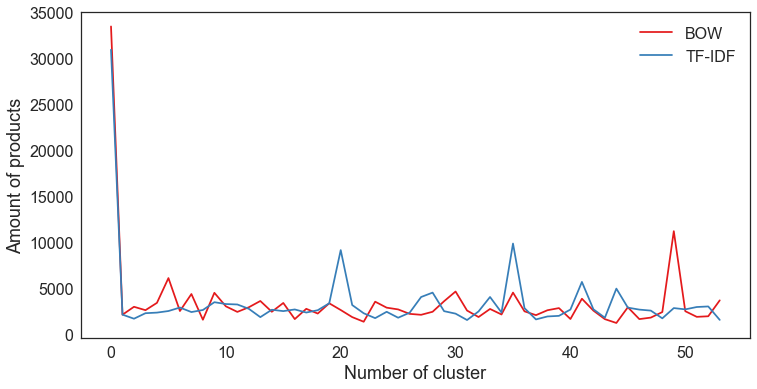

In [1074]:
plt.plot(list(df_bow.keys()), list(df_bow.values()), label='BOW')
plt.plot(list(df_tfidf.keys()), list(df_tfidf.values()), label='TF-IDF')
# Plot formatting
plt.legend(prop={'size': 16})
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)

In [1105]:
print("LDA BOW EN pick: ", max(list(df_bow.values())), " in cluster ", list(df_bow.keys())[list(df_bow.values()).index(max(list(df_bow.values())))])

LDA BOW EN pick:  33450  in cluster  0


In [1305]:
for i in range(20):
    print(en_lda.Nouns[en_lda.Topic_bow_index == 0].iloc[i])

power charger va
trillium xluais amazinguatriple hammock hardcore hammock market reinforced meters seat belt heavyduty ratchets safety stability comfort course views outdoors
veiniriiul
jigger mtubb horiz mm g
micro metal gearmotor rpm
toitepistik x mm
bruno tvalus
stmsdiscovery
combino n
marqäs sududgilaud
lingigarnituur pult kaart mm elsvp
muuuububuuuuuauõ kimberly
wemos d mini li battery charger shield
kitchenaid kthcbkitchenaid kthcb
uuuauuduuu
vurtu vira mm regulujama cinks valzn
apollo hurricane cc edasi manuaal
canne tvalus
fanatik eatable maus ubb mm
uuuuuuu


In [1106]:
print("LDA TF-IDF EN pick: ", max(list(df_tfidf.values())), " in cluster ", list(df_tfidf.keys())[list(df_tfidf.values()).index(max(list(df_tfidf.values())))])

LDA TF-IDF EN pick:  30922  in cluster  0


In [1307]:
for i in range(20):
    print(en_lda.Nouns[en_lda.Topic_tfidf_index == 0].iloc[i])

akrüülvärv stroke phthalo green ml
akrüülvärv stroke royal gold ml
veiniriiul
ladder ultra light ladder ultra light
jigger mtubb horiz mm g
toitepistik x mm
bruno tvalus
stmsdiscovery
combino n
marqäs sududgilaud
vintage laualamp
lingigarnituur pult kaart mm elsvp
muuuububuuuuuauõ kimberly
stroke brush nr
kitchenaid kthcbkitchenaid kthcb
uuuauuduuu
vurtu vira mm regulujama cinks valzn
apollo hurricane cc edasi manuaal
link pronks excbrs
canne tvalus


In [1111]:
print("LDA BOW ET pick: ", max(list(df_bow_et.values())), " in cluster ", list(df_bow_et.keys())[list(df_bow_et.values()).index(max(list(df_bow_et.values())))])

LDA BOW ET pick:  23054  in cluster  0


In [1308]:
for i in range(20):
    print(et_lda.Nouns[et_lda.Topic_bow_index == 0].iloc[i])

ehtekaart
kronstein zkujuline valefz
ehtekaart
kinkekott
alex kattemadrats
temperatuuriandur termistor
taaslateav eesnäärmevibraator vibratsioonieesnäärmevibraator brave
uuuub callista
romuralli klubi liikmeks soodustusi
jootejaam
peotelk
lillepostament mosaic dxhcm
nõrutusrest
ultrahelivann digital
kuumaalus
kontinentaalvoodi
venus kattemadrats
mega atmega
kuäuuu pluto
juukseklamber


In [1110]:
print("LDA TF-IDF ET pick: ", max(list(df_tfidf_et.values())), " in cluster ", list(df_tfidf_et.keys())[list(df_tfidf_et.values()).index(max(list(df_tfidf_et.values())))])

LDA TF-IDF ET pick:  22310  in cluster  0


In [1124]:
for i in range(10):
    print(et_lda.Nouns[et_lda.Topic_tfidf_index == 0].iloc[i])

ehtekaart
kronstein zkujuline valefz
ehtekaart
kinkekott
sügavus
alpaka siid
alex kattemadrats
temperatuuriandur termistor
taaslateav eesnäärmevibraator vibratsioonieesnäärmevibraator brave
uuuub callista


In [1109]:
df_bow_et = {k:0 for k in list(set(et_lda.Topic_bow_index))}
df_tfidf_et = {k:0 for k in list(set(et_lda.Topic_tfidf_index))}
for k in df_bow_et.keys():
    df_bow_et[k] = len(et_lda.Topic_bow_index[et_lda.Topic_bow_index == k])
for k in df_tfidf_et.keys():
    df_tfidf_et[k] = len(et_lda.Topic_tfidf_index[et_lda.Topic_tfidf_index == k])

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

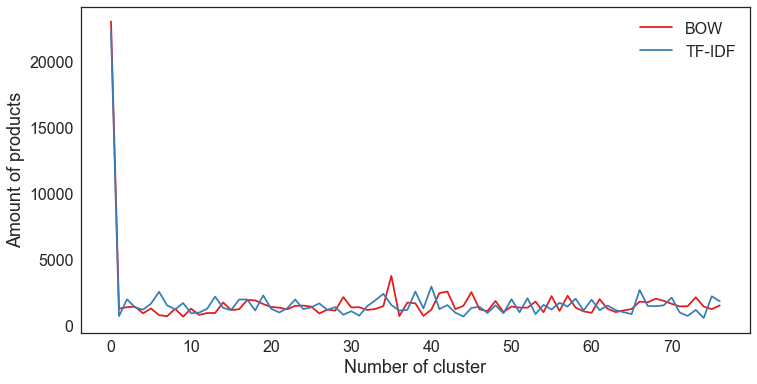

In [1075]:
plt.plot(list(df_bow_et.keys()), list(df_bow_et.values()), label='BOW')
plt.plot(list(df_tfidf_et.keys()), list(df_tfidf_et.values()), label='TF-IDF')
# Plot formatting
plt.legend(prop={'size': 16})
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)

In [1046]:
df_kmeans_en = {int(k):0 for k in list(set(en_kmeans_sep.Clusters))}
df_kmeans_et = {int(k):0 for k in list(set(et_kmeans_sep.Clusters))}
for k in df_kmeans_en.keys():
    df_kmeans_en[k] = len(en_kmeans_sep.Clusters[en_kmeans_sep.Clusters == str(k)])
for k in df_kmeans_et.keys():
    df_kmeans_et[k] = len(et_kmeans_sep.Clusters[et_kmeans_sep.Clusters == str(k)])

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

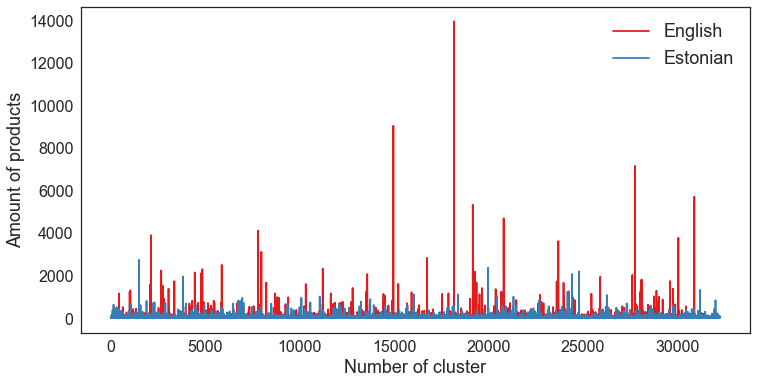

In [1077]:
plt.plot([k[0] for k in sorted(df_kmeans_en.items())], [k[1] for k in sorted(df_kmeans_en.items())], label='English')
plt.plot([k[0] for k in sorted(df_kmeans_et.items())], [k[1] for k in sorted(df_kmeans_et.items())], label='Estonian')
# Plot formatting
plt.legend(prop={'size': 18})
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)

In [1112]:
print("KMeans EN pick: ", max(list(df_kmeans_en.values())), " in cluster ", list(df_kmeans_en.keys())[list(df_kmeans_en.values()).index(max(list(df_kmeans_en.values())))])

KMeans EN pick:  13932  in cluster  18168


In [1310]:
for i in range(40):
    print(en_kmeans_sep.Nouns[en_kmeans_sep.Clusters == '18168'].iloc[i])

wcmortice lock mm steel ewclst
wcmortice lock mm silver ewcl
jigger mtubb horiz mm g
mortice lock mm epz
swarovski kivid crystal vitral light mm
toitepistik x mm
ratta adapter mm võllile
beautiful confetti creation art size confetti mm
lingigarnituur pult kaart mm elsvp
vurtu vira mm regulujama cinks valzn
fanatik eatable maus ubb mm
canon eos d efs mm is stm automaatne pilvine päevavalgus välk fluorestseeriv l vari tungsten lähivõte makro maastik portree portree sport ava eelistus automaatne manuaal film programm scene katiku prioriteet film slaidiseanss electrical patareicanon eos d efs mm is stm
metinamu mm valwhmmf
müüdud mm
m sisekuuskant poldid mm tk
swarovski kivid crystal ab mm
swarovski kivid smoked topaz mm
swarovski kivid rose mm
topsis swarovski suuruses sun mm
swarovski kivid crystal ab mm
müüdud mm kamee naisekujuga mm
osb plaat xx mm
wcmortice lock mm silver ewcr
sludzene wc durvubm mm nerubsujouais ewcrst
fanatik eatable mm
makerbeam mm anodeeritud
müüdud mm
osb xx mm
d

In [1113]:
print("KMeans ET pick: ", max(list(df_kmeans_et.values())), " in cluster ", list(df_kmeans_et.keys())[list(df_kmeans_et.values()).index(max(list(df_kmeans_et.values())))])

KMeans ET pick:  2733  in cluster  1474


In [1128]:
for i in range(10):
    print(et_kmeans_sep.Nouns[et_kmeans_sep.Clusters == '1474'].iloc[i])

toodetooted tõõpäeva jooksulsinulapse või kallima fotoga hõbedast medaljon kingitus lähed välja hind toodet graveerimistläbimõõt paksus mmkaal gkäsitõõna medaljonid pinnaga mistõttu hõbe metall inimtüüpide nahaga rolli tase ihupiimad kreemid tegu metalliga pilt või tingimustes medaljoni hambapasta hambaharjaga vahendeidfoto teksti saate hõlpsasti vormilt
võimalus lemmiklooma kadumist medaljon andmetega lemmiklooma leidjal omanike graveerija pildi järgi medaljon kondi või ümmargusele medaljonilekomplekti medaljon aas rõngas hind toodet graveerimist
kiirjahutusega hind plastpudeli maksumust pudel tagastamisele säilivus tarnepäevast päeva ubc mangutalu talupiim rasvasus
hind alusraami sõrestikku voodikasti voodile madrats suurusega cmvärv tamm sonoma grafiitmüüdudlaius cmkõrgus cmvoodi madagaskar
toodetooted tõõpäeva jooksulsinulapse või kallima fotoga hõbedast medaljon kingitus lähed välja hind toodet mmxmmxmmkaal gkäsitõõna medaljonid pinnaga mistõttu hõbe metall inimtüüpide nahaga roll

In [1134]:
df_tfidf_en = {k:0 for k in list(set(en_tfidf_sep.Clusters))}
df_tfidf_et = {k:0 for k in list(set(et_tfidf_sep.Clusters))}
for k in df_tfidf_en.keys():
    df_tfidf_en[k] = len(en_tfidf_sep.Clusters[en_tfidf_sep.Clusters == k])
for k in df_tfidf_et.keys():
    df_tfidf_et[k] = len(et_tfidf_sep.Clusters[et_tfidf_sep.Clusters == k])

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

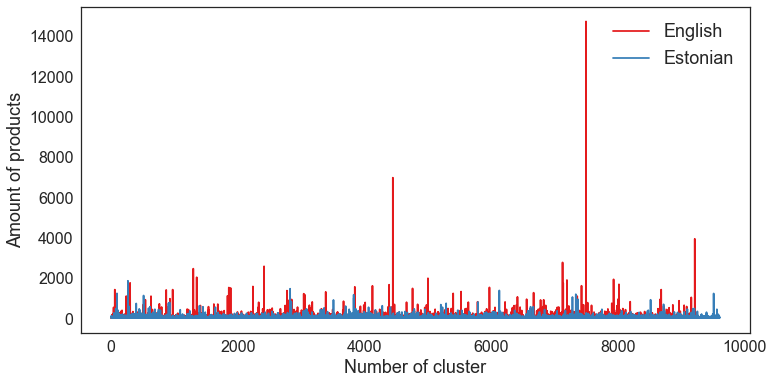

In [1082]:
plt.plot([k[0] for k in sorted(df_tfidf_en.items())], [k[1] for k in sorted(df_tfidf_en.items())], label='English')
plt.plot([k[0] for k in sorted(df_tfidf_et.items())], [k[1] for k in sorted(df_tfidf_et.items())], label='Estonian')
# Plot formatting
plt.legend(prop={'size': 18})
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)

In [1137]:
print("TF-IDF EN pick: ", max(list(df_tfidf_en.values())), " in cluster ", list(df_tfidf_en.keys())[list(df_tfidf_en.values()).index(max(list(df_tfidf_en.values())))])

TF-IDF EN pick:  14718  in cluster  7495


In [1138]:
for i in range(10):
    print(en_tfidf_sep.Nouns[en_tfidf_sep.Clusters == 7495].iloc[i])

wcmortice lock mm steel ewclst
wcmortice lock mm silver ewcl
jigger mtubb horiz mm g
mortice lock mm epz
ratta adapter mm võllile
lingigarnituur pult kaart mm elsvp
fanatik eatable maus ubb mm
metinamu mm valwhmmf
müüdud mm
m sisekuuskant poldid mm tk


In [1135]:
print("TF-IDF ET pick: ", max(list(df_tfidf_et.values())), " in cluster ", list(df_tfidf_et.keys())[list(df_tfidf_et.values()).index(max(list(df_tfidf_et.values())))])

TF-IDF ET pick:  1846  in cluster  267


In [1136]:
for i in range(10):
    print(et_tfidf_sep.Nouns[et_tfidf_sep.Clusters == 0].iloc[i])

liiki otto diiselmootorite turbolaadimisega jaua jõuülekande agregaatide õlitussüsteemide puhastamiseks mustuse vaigu sadestised õlikanalitest läbitõõtanud õliga minemavitaflush mootori õlitussüsteemi
liiki otto diiselmootorite turbolaadimisega jaua jõuülekande agregaatide õlitussüsteemide puhastamiseks mustuse vaigu sadestised õlikanalitest läbitõõtanud õliga minemavitaflush mootori õlitussüsteemi
liiki otto diiselmootorite turbolaadimisega jaua jõuülekande agregaatide õlitussüsteemide puhastamiseks mustuse vaigu sadestised õlikanalitest läbitõõtanud õliga minemavitaflush mootori õlitussüsteemi
liiki otto diiselmootorite turbolaadimisega jaua jõuülekande agregaatide õlitussüsteemide puhastamiseks mustuse vaigu sadestised õlikanalitest läbitõõtanud õliga minemavitaflush mootori õlitussüsteemi
liiki otto diiselmootorite turbolaadimisega jaua jõuülekande agregaatide õlitussüsteemide puhastamiseks mustuse vaigu sadestised õlikanalitest läbitõõtanud õliga minemavitaflush mootori õlitussüst

In [1034]:
df_dbscan_en = {k:0 for k in list(set(en_dbscan.Cluster))}
df_dbscan_et = {k:0 for k in list(set(et_dbscan.Cluster))}
for k in df_dbscan_en.keys():
    df_dbscan_en[k] = len(en_dbscan.Cluster[en_dbscan.Cluster == k])
for k in df_dbscan_et.keys():
    df_dbscan_et[k] = len(et_dbscan.Cluster[et_dbscan.Cluster == k])

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

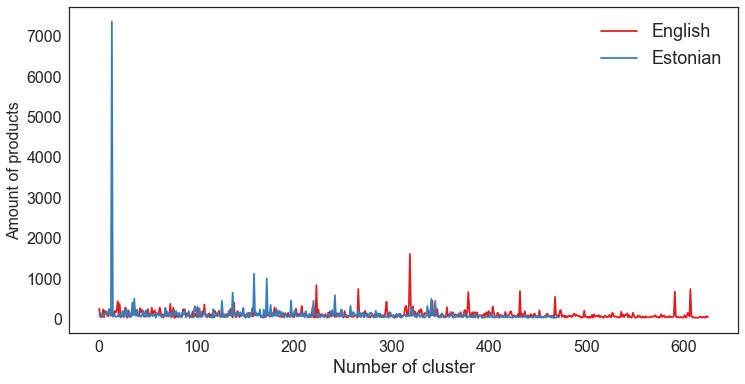

In [1083]:
plt.plot([k[0] for k in sorted(df_dbscan_en.items())], [k[1] for k in sorted(df_dbscan_en.items())], label='English')
plt.plot([k[0] for k in sorted(df_dbscan_et.items())], [k[1] for k in sorted(df_dbscan_et.items())], label='Estonian')
# Plot formatting
plt.legend(prop={'size': 18})
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)
plt.ylabel('Amount of products', fontsize=16)
#outlier et: #13

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

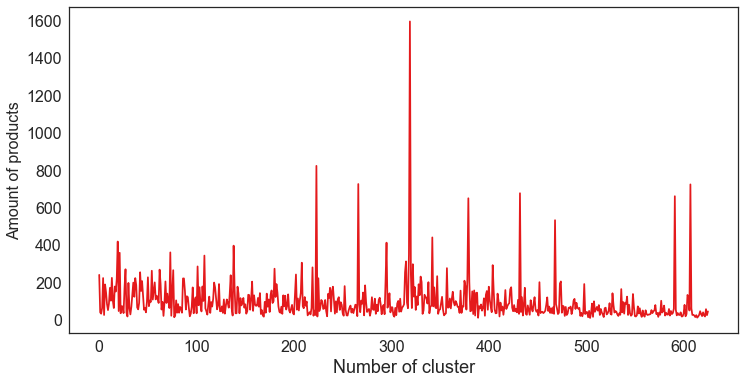

In [1084]:
plt.plot([k[0] for k in sorted(df_dbscan_en.items())], [k[1] for k in sorted(df_dbscan_en.items())], label='English')
# Plot formatting
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)
plt.ylabel('Amount of products', fontsize=16)
#outlier et: #13

In [1139]:
print("DBSCAN EN pick: ", max(list(df_dbscan_en.values())), " in cluster ", list(df_dbscan_en.keys())[list(df_dbscan_en.values()).index(max(list(df_dbscan_en.values())))])

DBSCAN EN pick:  1593  in cluster  319


In [1311]:
for i in range(40):
    print(en_dbscan.Nouns[en_dbscan.Cluster == 319].iloc[i])

beautiful swarovski rhinestones jars jarsize mmswarovski rhinestones crystal mm
kristalliduaaroshirva ssvärv crystal aurora borealeliim hotfixpakkua tk tk
beautiful swarovski rhinestones jars jarsize mmswarovski rhinestones crystal mm
crystal comet
mm crystal white patina
crystal
crystal
crystal
mm crystal lilac shadow
mm crystal pastel
price grams kg please note pictures illustrationinformation color swatches purposes colors screen monitor settings browsersdb crystal
mm crystal vitrail medium
mm crystal lilac shadow
crystal
mm crystal bermuda blä
mm crystal blä shade
mm crystal light creamrose
mm crystal lilac shadow
efcmecl crankset speed black fcm t mm
mm crystal aurore boreale
ssmm crystal
crystal
mm crystal pendants
mm crystal celsian
crystal
mm crystal bermuda blä
mm crystal lilac shadow
mm crystal celsian
mm crystal labrador full
mm crystal golden shadow
crystal
mm crystal
crystal
armunukk dreamy corella crystal
mm crystal golden shadow
crystal õuäuuuuudubu
mm crystal bermuda bl

C:\Users\Olha\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Amount of products')

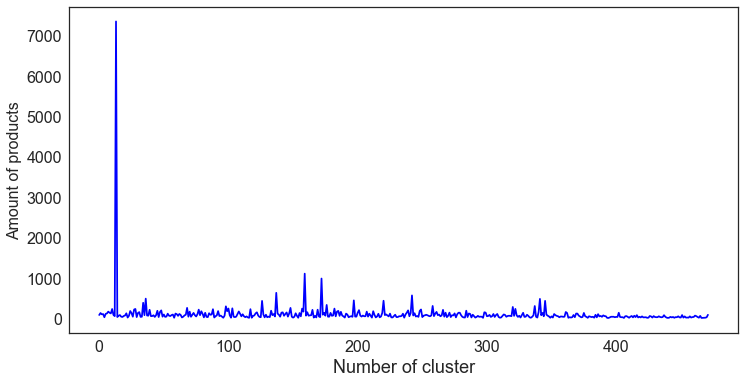

In [1092]:
plt.plot([k[0] for k in sorted(df_dbscan_et.items())], [k[1] for k in sorted(df_dbscan_et.items())], 'b',  label='Estonian')
# Plot formatting
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Amount of products', fontsize=18)
plt.ylabel('Amount of products', fontsize=16)
#outlier et: #13

In [1141]:
print("DBSCAN ET pick: ", max(list(df_dbscan_et.values())), " in cluster ", list(df_dbscan_et.keys())[list(df_dbscan_et.values()).index(max(list(df_dbscan_et.values())))])

DBSCAN ET pick:  7351  in cluster  13


In [1312]:
for i in range(40):
    print(et_dbscan.Nouns[et_dbscan.Cluster == 13].iloc[i])

alumiiniumtoru läbimõõt uaudcm udclemised torud udmm küljed kangas oxford värv või
sensoriga armukuul treening lelu aru lihased treeningimpulssenäed lihased gballs
jänkuvibraatorit topeltvibraatorit peeniserõngast või vibraator asendisse udcks ümaratest peadest lisastimulatsiooni kujuga vibraator shanky vibe
uuubäuäu uuuuuduauäuuuuc bergen
roosad taset nibuklambrid puldist juhe cmtõõtab xaa patareiga komplektis võid patareide altnibuklambrid õrritajad
majapidamispaberi hoidja
ethernet laiendusplaat arduinole
rippkiik materjalist üles mõnulemiseks magamiseks märjal või mägisel pinnaselua
majapidamispaberi hoidja
uuubäuäu uuuuuduauäuuuuc bergen
roosad taset nibuklambrid puldist juhe cmtõõtab xaa patareiga komplektis võid patareide altnibuklambrid õrritajad
vibreerimisfunktsiooniga disainiga gpunkti vibraator
majapidamispaberi hoidja
kauss puuviljadele
majapidamispaberi hoidja
valmistatud plaadist toode detailidena kokkupanemist koguses
roosad taset nibuklambrid puldist juhe cmtõõtab xaa 

In [1177]:
# Measurments

def measure_lonely_prod(df, clust_prod):
    #clusters_1 = list(set([int(k) for k in list(clust_prod.keys())[list(clust_prod.values()).index(1)]]))
    clusters_1 = []
    for k in clust_prod.keys():
        if clust_prod[k] == 1:
            clusters_1.append(k)
    sample_cl1 = df[df['Clusters'].isin(clusters_1)]
    lonely = list(set(sample_cl1['node']))
    all_lonely = []
    for l in lonely:
        sample = df[df['node'] == l]
        clusters = list(set(sample['Clusters']))
        if len(set(clusters_1)-set(clusters)) == 0:
            all_lonely.append(l)
    if len(all_lonely) == 0:
        print("All products are connected.")
    else:
        print("Amount of connected products: ", (len(list(set(df['node'])))-len(all_lonely))/len(list(set(df['node'])))*100, "%")
    return clusters_1, lonely, all_lonely

In [1178]:
clusters_1_en_kmeans, lonely, all_lonely_en_kmeans = measure_lonely_prod(en_kmeans_sep, clust_prod_en_kmeans)

All products are connected.


In [1179]:
clusters_1_et_kmeans, lon_k_et, all_lonely_et_kmeans = measure_lonely_prod(et_kmeans_sep, clust_prod_et_kmeans)

All products are connected.


In [1180]:
clusters_1_en_tfidf, lonely_en_tf, all_lonely_en_tfidf = measure_lonely_prod(en_tfidf_sep, clust_prod_en_tfidf)

All products are connected.


In [1181]:
clusters_1_et_tfidf, lonely_et_tf, all_lonely_et_tfidf = measure_lonely_prod(et_tfidf_sep, clust_prod_et_tfidf)

All products are connected.


In [55]:
companies = []
for i in en_lda.link:
    comp = i.split('/')[0].replace('<', '').replace('www', '').replace('https', '').replace('http', '').replace(':', '')
    if comp[0] == '.':
        comp = comp[1:]
    companies.append(comp)
companies = list(set(companies))
print(len(companies))

771


In [63]:
companies.remove('likealocalguide.com')

In [64]:
import itertools
minimum = 40
df = en_lda
cluster_col = 'Topic_bow_index'
for subset in itertools.combinations(companies, 2):
    i = subset[0]
    j = subset[1]
    prod2 = list(set(df.node[df['link'].str.contains(i)]))
    prod3 = list(set(df.node[df['link'].str.contains(j)]))
    if i != j and abs((len(prod2)-len(prod3))/(len(prod2)+len(prod3))) < 0.1:
        sampe2 = df[df['link'].str.contains(i)]
        sampe3 = df[df['link'].str.contains(j)]
        clusters2 = list(set(sampe2[cluster_col]))
        clusters3 = list(set(sampe3[cluster_col]))
        inter_clust23 = list(set(clusters3) & set(clusters2))
        prod23 = list(set(df.node[df.node.isin(prod3+prod2) & df[cluster_col].isin(inter_clust23)]))
        score = len(prod23)/(len(prod2)+len(prod3))*100
        if score < minimum:
            print("The low percentage: ", score, " for ", i, " and ", j)
print("The lowest percentage: ", minimum, " for ", comp_i, " and ", comp_j)

The low percentage:  38.88888888888889  for  tatalus.ee  and  fertan.ie
The low percentage:  0.0  for  tatalus.ee  and  versus.ee
The low percentage:  0.0  for  tatalus.ee  and  bestkiteboarding.com
The low percentage:  0.0  for  tatalus.ee  and  kannukas.ee
The low percentage:  0.0  for  tatalus.ee  and  hcgym.eu
The low percentage:  0.0  for  tatalus.ee  and  gogonano.com
The low percentage:  0.0  for  tatalus.ee  and  e-arvutipood.ee
The low percentage:  0.0  for  tatalus.ee  and  xn--ktertikuivatid-5hbd.ee
The low percentage:  0.0  for  tatalus.ee  and  grecko.themerex.net
The low percentage:  0.0  for  tatalus.ee  and  hansakamin.ee
The low percentage:  0.0  for  tatalus.ee  and  classter.themerex.net
The low percentage:  0.0  for  tatalus.ee  and  mommila.ee
The low percentage:  39.53488372093023  for  bigshop.ee  and  presteamshop.com
The low percentage:  38.93129770992366  for  bigshop.ee  and  sushivelvet.ee
The low percentage:  23.50597609561753  for  bigshop.ee  and  tamberi

KeyboardInterrupt: 

In [68]:
def check_companies(comp1, comp2, comp3, df, cluster_col):
    prod1 = list(set(df.node[df['link'].str.contains(comp1)]))
    prod2 = list(set(df.node[df['link'].str.contains(comp2)]))
    prod3 = list(set(df.node[df['link'].str.contains(comp3)]))
   # print("Number of products in ", comp1, " is ", len(prod1))
    print("Number of products in ", comp2, " is ", len(prod2))
    print("Number of products in ", comp3, " is ", len(prod3))
    sampe1 = df[df['link'].str.contains(comp1)]
    sampe2 = df[df['link'].str.contains(comp2)]
    sampe3 = df[df['link'].str.contains(comp3)]
    clusters1 = list(set(sampe1[cluster_col]))
    clusters2 = list(set(sampe2[cluster_col]))
    clusters3 = list(set(sampe3[cluster_col]))
    inter_clust12 = list(set(clusters1) & set(clusters2))
    inter_clust13 = list(set(clusters1) & set(clusters3))
    inter_clust23 = list(set(clusters3) & set(clusters2))
    prod12 = list(set(df.node[df.node.isin(prod1+prod2) & df[cluster_col].isin(inter_clust12)]))
    prod12_1 = list(set(df.node[df.node.isin(prod1) & df[cluster_col].isin(inter_clust12)]))
    prod12_2 = list(set(df.node[df.node.isin(prod2) & df[cluster_col].isin(inter_clust12)]))
    prod23 = list(set(df.node[df.node.isin(prod3+prod2) & df[cluster_col].isin(inter_clust23)]))
    prod23_2 = list(set(df.node[df.node.isin(prod2) & df[cluster_col].isin(inter_clust23)]))
    prod23_3 = list(set(df.node[df.node.isin(prod3) & df[cluster_col].isin(inter_clust23)]))
    prod13 = list(set(df.node[df.node.isin(prod1+prod3) & df[cluster_col].isin(inter_clust13)]))
    prod13_1 = list(set(df.node[df.node.isin(prod1) & df[cluster_col].isin(inter_clust13)]))
    prod13_3 = list(set(df.node[df.node.isin(prod3) & df[cluster_col].isin(inter_clust13)]))
   # print("The common products for ", comp1, " and ", comp2, " is ", len(prod12), ' where ', len(prod12_1), 'is from 1st company and ', len(prod12_2) , 'from 2nd')
    print("The common products in ", comp2, " is ", len(prod23_2)/len(prod2)*100)#, ' where ', len(prod23_2), 'is from 1st company and ', len(prod23_3), 'from 2nd')
    print("The common products in ", comp3, " is ", len(prod23_3)/len(prod3)*100)
    print("The percentage of connected products among all ", len(prod23)/(len(prod2)+len(prod3))*100)
    # print("The common products for ", comp1, " and ", comp3, " is ", len(prod13), ' where ', len(prod13_1), 'is from 1st company and ', len(prod13_3), 'from 2nd')
    #print("Diffrence: ", len(prod2)-len(prod23_2) , "for first, ", len(prod3)-len(prod23_3) ,' for second')
    return prod12, prod23, prod13
'''
The low percentage:  

    4.743083003952568  for  'bigshop.ee', 'kaekellad.ee'
    9.523809523809524  for  'arvutiakud.ee', 'sensuale.ee'
    4.093567251461988  for  'smarta.ee', 'all4pet.ee'
'''
prod12, prod23, prod13 = check_companies('koreacosmetics.eu', 'smarta.ee', 'all4pet.ee', en_lda, 'Topic_bow_index')

Number of products in  smarta.ee  is  240
Number of products in  elvogue.com  is  272
The common products in  smarta.ee  is  17.5
The common products in  elvogue.com  is  13.602941176470587
The percentage of connected products among all  15.4296875


In [69]:
list(set(en_lda.Nouns[en_lda.node.isin(prod23)]))

['marc aurel black formal dress eumarc aurelsize eu smclassic wool dresssequin zipperknit polyester wool new conditionmodel product diana tall wears aurel black formal wool dress eu',
 'boss orangesize eunude leather wedgeback zipperheel box dust loved conditionboss orange wedges eu',
 'michael korsselma saffiano cow leathergoldtone hardware studdsmichael kors logo strapone pocket zipper closuremany polyester monogram leather feet bagmany dark back bagmeasurements panel cacm bottom loved conditionmichael kors selma satchel',
 'otterbox commuter series case cover htc one mini glacier',
 'francesco biasiashoulder shoulder leatherreal fur detailssingle pocketzipper closuremeasurements length loved conditionfrancesco biasia shoulder bag',
 'otterbox clearly protected sony xperia sp',
 'vent mount universal black',
 'otterbox clearly skin iphone s seotterbox clearly skin iphone s se',
 'iris janvier aline wool dress siris janvier vera lustinasize s mmustard coloreduaaline wool zippercomposi

In [70]:
list(set(en_lda.Nouns[~en_lda.node.isin(prod23) & en_lda.link.str.contains('smarta.ee')]))

['otterbox clearly skin walpha glass iphone s se',
 'holdit style phone case iphone s flamingo bloom',
 'holdit style phone case iphone s pretty pink',
 'fashion case aw iphone aurora red',
 'fashion case aw iphone marrakech',
 'otterbox defender samsung galaxy tabpro samsung galaxy note edition glacier',
 'holdit style phone case iphone s ming blä',
 'otterbox strada alpha glass apple iphone serpent u editionud',
 'fashion case ss iphone ses island paradise marble',
 'otterbox prefix series case apple iphone s carbon',
 'fashion case ss iphone ses copper',
 'otterbox strada samsung galaxy s brunt saddle',
 'holdit selected lucngasand phone case iphone s black silke',
 'otterbox strada samsung galaxy s phantom blackotterbox strada samsung galaxy s phantom blacks',
 'otterbox preserver case iphone carbon',
 'holdit selected apelviken wallet case iphone s black leather',
 'holdit selected skrea wallet case iphone s black leathersäde',
 'otterbox symmetry iphone black',
 'otterbox symmetr

In [71]:
list(set(en_lda.Nouns[~en_lda.node.isin(prod23) & en_lda.link.str.contains('all4pet.ee')]))

['hillubs sp feline mature adult active longevity chicken',
 'royal canin german shepherd adult pakki pakk tasuta kg',
 'hillubs natures best feline mature chicken',
 'royal canin golden retriever junior kg',
 'royal canin kitten',
 'royal canin labrador retriever junior kg',
 'orijen dog senior',
 'royal canin ultra light jelly g',
 'royal canin dachshund adult kg',
 'royal canin bengal adult',
 'hillus sp puppy small miniature chicken',
 'hillus sp feline mature adult g',
 'brit premium senior l',
 'brit care cat missy',
 'acana dog pacifica',
 'hillubs sp feline adult optimal care tuna',
 'brit care adult large breed lamb rice',
 'royal canin urban life junior wet g',
 'hillubs sp canine adult advanced fitness medium tuna rice',
 'acana heritage dog puppy junior',
 'brit care cat crazy iubm kitten',
 'brit care puppy grainfree salmonpotato',
 'royal canin mini exigent',
 'royal canin sport life agility small dog',
 'hillus sp hd feline kitten multipack kanamerekala g',
 'royal canin

In [110]:
prod12_tf, prod23_tf, prod13_tf = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', en_lda, 'Topic_tfidf_index')

Number of products in  smarta.ee  is  240
Number of products in  all4pet.ee  is  273
The common products in  smarta.ee  is  15.833333333333332
The common products in  all4pet.ee  is  94.5054945054945
The percentage of connected products among all  57.69980506822612


In [75]:
list(set(en_lda.Nouns[en_lda.node.isin(prod23_tf)]))

['hillubs sp feline mature adult active longevity chicken',
 'royal canin german shepherd adult pakki pakk tasuta kg',
 'hillubs natures best feline mature chicken',
 'royal canin golden retriever junior kg',
 'royal canin kitten',
 'royal canin labrador retriever junior kg',
 'royal canin ultra light jelly g',
 'royal canin dachshund adult kg',
 'royal canin bengal adult',
 'hillus sp feline mature adult g',
 'acana dog pacifica',
 'hillubs sp feline adult optimal care tuna',
 'brit care adult large breed lamb rice',
 'royal canin urban life junior wet g',
 'hillubs sp canine adult advanced fitness medium tuna rice',
 'acana heritage dog puppy junior',
 'brit care cat crazy iubm kitten',
 'otterbox clearly protected samsung htc mini',
 'royal canin mini exigent',
 'otterbox clearly protected lg optimus l ii',
 'royal canin sport life agility small dog',
 'hillus sp hd feline kitten multipack kanamerekala g',
 'royal canin babycat milk g',
 'hillubs sp feline adult liver chicken',
 'ro

In [74]:
list(set(en_lda.Nouns[~en_lda.node.isin(prod23_tf) & en_lda.link.str.contains('smarta.ee')]))

['otterbox clearly skin walpha glass iphone s se',
 'holdit style phone case iphone s flamingo bloom',
 'holdit style phone case iphone s pretty pink',
 'fashion case aw iphone aurora red',
 'otterbox clearly skin iphone s seotterbox clearly skin iphone s se',
 'fashion case aw iphone marrakech',
 'otterbox defender samsung galaxy tabpro samsung galaxy note edition glacier',
 'holdit style phone case iphone s ming blä',
 'magnet wallet iphone plus black',
 'otterbox strada alpha glass apple iphone serpent u editionud',
 'fashion case ss iphone ses island paradise marble',
 'otterbox prefix series case apple iphone s carbon',
 'otterbox commuter series cover case htc one m black',
 'fashion case ss iphone ses copper',
 'otterbox strada samsung galaxy s brunt saddle',
 'holdit selected lucngasand phone case iphone s black silke',
 'otterbox strada samsung galaxy s phantom blackotterbox strada samsung galaxy s phantom blacks',
 'otterbox preserver case iphone carbon',
 'holdit selected ap

In [76]:
list(set(en_lda.Nouns[~en_lda.node.isin(prod23_tf) & en_lda.link.str.contains('all4pet.ee')]))

['brit care cat chicken cheese kitten g',
 'brit care cat chickenduck g',
 'brit care cat angel iubm delighted senior',
 'brit care cat chicken cheese g',
 'acana classics dog classic red',
 'brit care puppy grainfree salmonpotato',
 'orijen dog senior',
 'brit care cat missy',
 'orijen dog puppy',
 'brit care cat lilly iubve sensitive digestion',
 'hillubs natureus best puppy minimedium chicken',
 'hillus sp puppy small miniature chicken',
 'brit premium senior l']

In [77]:
prod12_km, prod23_km, prod13_km = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', en_kmeans_sep, 'Clusters')

Number of products in  smarta.ee  is  240
Number of products in  all4pet.ee  is  273
The common products in  smarta.ee  is  11.25
The common products in  all4pet.ee  is  72.52747252747253
The percentage of connected products among all  43.859649122807014


In [78]:
list(set(en_kmeans_sep.Nouns[en_kmeans_sep.node.isin(prod23_km)]))

['hillubs sp feline mature adult active longevity chicken',
 'royal canin german shepherd adult pakki pakk tasuta kg',
 'royal canin golden retriever junior kg',
 'royal canin kitten',
 'otterbox clearly skin walpha glass iphone s se',
 'royal canin labrador retriever junior kg',
 'fashion case aw iphone aurora red',
 'otterbox clearly skin iphone s seotterbox clearly skin iphone s se',
 'royal canin dachshund adult kg',
 'royal canin bengal adult',
 'hillus sp puppy small miniature chicken',
 'hillus sp feline mature adult g',
 'brit premium senior l',
 'hillubs sp feline adult optimal care tuna',
 'hillubs sp canine adult advanced fitness medium tuna rice',
 'otterbox clearly protected samsung htc mini',
 'royal canin mini exigent',
 'otterbox clearly protected lg optimus l ii',
 'royal canin sport life agility small dog',
 'hillus sp hd feline kitten multipack kanamerekala g',
 'hillubs sp feline adult liver chicken',
 'royal canin labrador retriever adult kg',
 'royal canin intense

In [79]:
list(set(en_kmeans_sep.Nouns[~en_kmeans_sep.node.isin(prod23_km) & en_kmeans_sep.link.str.contains('smarta.ee')]))

['holdit style phone case iphone s flamingo bloom',
 'holdit style phone case iphone s pretty pink',
 'fashion case aw iphone marrakech',
 'otterbox defender samsung galaxy tabpro samsung galaxy note edition glacier',
 'holdit style phone case iphone s ming blä',
 'magnet wallet iphone plus black',
 'otterbox strada alpha glass apple iphone serpent u editionud',
 'fashion case ss iphone ses island paradise marble',
 'otterbox prefix series case apple iphone s carbon',
 'otterbox commuter series cover case htc one m black',
 'fashion case ss iphone ses copper',
 'otterbox strada samsung galaxy s brunt saddle',
 'holdit selected lucngasand phone case iphone s black silke',
 'otterbox strada samsung galaxy s phantom blackotterbox strada samsung galaxy s phantom blacks',
 'otterbox preserver case iphone carbon',
 'holdit selected apelviken wallet case iphone s black leather',
 'holdit selected skrea wallet case iphone s black leathersäde',
 'otterbox symmetry iphone black',
 'otterbox symm

In [80]:
list(set(en_kmeans_sep.Nouns[~en_kmeans_sep.node.isin(prod23_km) & en_kmeans_sep.link.str.contains('all4pet.ee')]))

['brit care puppy all breed lamb rice hüpoallergeenne toit iga tõugu kuudbrit care puppy all breed lamb rice',
 'royal canin indoor long hair',
 'hillubs natures best feline mature chicken',
 'acana heritage dog puppy sb',
 'orijen dog senior',
 'royal canin ultra light jelly g',
 'hillubs natureubs best canine adult largegiant chicken',
 'beaphar maltbits cat original',
 'brit care cat missy',
 'royal canin cavalier king charles adult kg',
 'acana dog pacifica',
 'beaphar junior cal g',
 'brit care cat angel iubm delighted senior',
 'brit care adult large breed lamb rice',
 'hillubs natures best feline adult chicken',
 'royal canin urban life junior wet g',
 'acana heritage dog puppy junior',
 'brit care cat crazy iubm kitten',
 'brit care puppy grainfree salmonpotato',
 'brit care adult medium breed lamb rice',
 'acana sport agility dog',
 'hillubs natures best feline adult tuna',
 'beaphar brewers yeast tablets',
 'beaphar cat snaps multivitamiini tabletid cat snaps multivitamiini t

In [81]:
prod12_kwtf, prod23_kwtf, prod13_kwtf = check_companies('koreacosmetics.eu', 'smarta.ee', 'all4pet.ee', en_tfidf_sep, 'Clusters')

Number of products in  smarta.ee  is  239
Number of products in  all4pet.ee  is  271
The common products in  smarta.ee  is  2.928870292887029
The common products in  all4pet.ee  is  46.125461254612546
The percentage of connected products among all  25.882352941176475


In [82]:
list(set(en_tfidf_sep.Nouns[en_tfidf_sep.node.isin(prod23_kwtf)]))

['royal canin german shepherd adult pakki pakk tasuta kg',
 'royal canin xsmall adult',
 'royal canin beagle adult kg',
 'royal canin golden retriever junior kg',
 'hillubs sp feline adult ocean fish',
 'royal canin kitten',
 'royal canin ultra light g',
 'royal canin poodle junior kg',
 'royal canin sensible',
 'fashion case aw iphone ocean marble',
 'royal canin maxi dermacomfort',
 'orijen cat regional red',
 'fashion case aw iphone aurora red',
 'royal canin ultra light jelly g',
 'royal canin ageing',
 'royal canin dachshund adult kg',
 'royal canin bengal adult',
 'royal canin mini dermacomfort',
 'royal canin babycat instinctive konserv g',
 'royal canin ageing g',
 'royal canin mini junior kg',
 'royal canin mother babycat',
 'royal canin maxi junior kg',
 'royal canin medium dermacomfort',
 'royal canin medium junior kg',
 'royal canin mini exigent',
 'royal canin sphynx',
 'royal canin appetite control',
 'hillus sp feline mature adult ocean fish g',
 'royal canin oral sensit

In [83]:
list(set(en_tfidf_sep.Nouns[~en_tfidf_sep.node.isin(prod23_kwtf) & en_tfidf_sep.link.str.contains('smarta.ee')]))

['otterbox clearly skin walpha glass iphone s se',
 'holdit style phone case iphone s flamingo bloom',
 'holdit style phone case iphone s pretty pink',
 'otterbox clearly skin iphone s seotterbox clearly skin iphone s se',
 'fashion case aw iphone marrakech',
 'otterbox defender samsung galaxy tabpro samsung galaxy note edition glacier',
 'holdit style phone case iphone s ming blä',
 'magnet wallet iphone plus black',
 'otterbox strada alpha glass apple iphone serpent u editionud',
 'fashion case ss iphone ses island paradise marble',
 'otterbox prefix series case apple iphone s carbon',
 'otterbox commuter series cover case htc one m black',
 'fashion case ss iphone ses copper',
 'otterbox strada samsung galaxy s brunt saddle',
 'otterbox clearly protected samsung htc mini',
 'holdit selected lucngasand phone case iphone s black silke',
 'otterbox clearly protected lg optimus l ii',
 'otterbox strada samsung galaxy s phantom blackotterbox strada samsung galaxy s phantom blacks',
 'ott

In [84]:
list(set(en_tfidf_sep.Nouns[~en_tfidf_sep.node.isin(prod23_kwtf) & en_tfidf_sep.link.str.contains('all4pet.ee')]))

['hillubs sp feline mature adult active longevity chicken',
 'hillubs natures best feline mature chicken',
 'royal canin labrador retriever junior kg',
 'orijen dog senior',
 'hillus sp puppy small miniature chicken',
 'hillus sp feline mature adult g',
 'brit care cat missy',
 'brit premium senior l',
 'acana dog pacifica',
 'hillubs sp feline adult optimal care tuna',
 'brit care adult large breed lamb rice',
 'royal canin urban life junior wet g',
 'hillubs sp canine adult advanced fitness medium tuna rice',
 'acana heritage dog puppy junior',
 'brit care cat crazy iubm kitten',
 'brit care puppy grainfree salmonpotato',
 'royal canin sport life agility small dog',
 'hillus sp hd feline kitten multipack kanamerekala g',
 'hillubs sp feline adult liver chicken',
 'royal canin labrador retriever adult kg',
 'hillubs sp canine mature adult small miniature',
 'hillus sp feline mature adult turkey g',
 'brit care light turkey rice',
 'hillubs sp feline adult light chicken',
 'hillubs sp 

In [85]:
prod12_db, prod23_db, prod13_db = check_companies('koreacosmetics.eu', 'smarta.ee', 'all4pet.ee', en_dbscan, 'Cluster')

Number of products in  smarta.ee  is  42
Number of products in  all4pet.ee  is  95
The common products in  smarta.ee  is  16.666666666666664
The common products in  all4pet.ee  is  6.315789473684211
The percentage of connected products among all  9.48905109489051


In [86]:
list(set(en_dbscan.Nouns[en_dbscan.node.isin(prod23_db)]))

['otterbox clearly skin iphone s walpha glass bundleotterbox clearly skin iphone s walpha glass bundle',
 'royal canin mini mature',
 'royal canin mini dermacomfort',
 'otterbox clearly protected samsung htc mini',
 'royal canin mini exigent',
 'otterbox clearly protected sony xperia sp',
 'hillubs sp puppy healthy development lamb rice',
 'otterbox clearly skin iphone s seotterbox clearly skin iphone s se',
 'hillubs sp canine adult sensitive skin chicken',
 'otterbox symmetry folio ipad mini glacier']

In [87]:
list(set(en_dbscan.Nouns[~en_dbscan.node.isin(prod23_db) & en_dbscan.link.str.contains('smarta.ee')]))

['otterbox strada samsung galaxy s black',
 'fashion case spring summer iphone floral romance',
 'fashion case ss iphone ses silver',
 'otterbox single port eu wall charger amp',
 'otterbox defender samsung galaxy tabpro samsung galaxy note edition glacier',
 'lifeproof fre apple iphone black',
 'lifeproof fre power case apple iphone s asphalt',
 'otterbox symmetry clear iphone black crystal',
 'otterbox prefix series case apple iphone s carbon',
 'otterbox commuter series cover case htc one m black',
 'oterbox clearly cover macbook pro retina',
 'otterbox preserver case iphone carbon',
 'fashion case aw iphone boho',
 'start kit monitor',
 'otterbox symmetry iphone black',
 'otterbox commuter black samsung galaxy s',
 'fashion case ss iphone s peach echo',
 'otterbox defender series htc one x iris',
 'copper pronksuaideal sweden moekollektsioonajatu nagu ta pronks alati moevärvide seas maailmafashion case ss iphone s copper',
 'fashion case ss iphone s copper',
 'otterbox clearly prot

In [88]:
list(set(en_dbscan.Nouns[~en_dbscan.node.isin(prod23_db) & en_dbscan.link.str.contains('all4pet.ee')]))

['hillubs sp feline mature adult light chicken kg',
 'royal canin xsmall adult',
 'royal canin indoor long hair',
 'royal canin beagle adult kg',
 'royal canin golden retriever junior kg',
 'royal canin labrador retriever junior kg',
 'orijen cat regional red',
 'royal canin bengal adult',
 'royal canin dachshund adult kg',
 'hillus sp feline mature adult g',
 'brit care cat missy',
 'brit premium senior l',
 'royal canin cavalier king charles adult kg',
 'royal canin ageing g',
 'royal canin mini junior kg',
 'acana dog pacifica',
 'royal canin maxi junior kg',
 'brit care adult large breed lamb rice',
 'royal canin medium dermacomfort',
 'hillubs sp feline adult mix chickenturkey g',
 'acana heritage dog puppy junior',
 'royal canin medium junior kg',
 'brit care adult medium breed lamb rice',
 'acana heritage dog senior',
 'hillubs sp feline mature adult hairball control chicken kg',
 'royal canin indoor life adult small dog',
 'acana heritage dog sportagiliti',
 'hillubs sp feline 

In [89]:
etprod12, etprod23, etprod13 = check_companies('koreacosmetics.eu', 'smarta.ee', 'all4pet.ee', et_lda, 'Topic_bow_index')

Number of products in  smarta.ee  is  5
Number of products in  all4pet.ee  is  4
The common products in  smarta.ee  is  0.0
The common products in  all4pet.ee  is  0.0
The percentage of connected products among all  0.0


In [90]:
list(set(et_lda.Nouns[et_lda.node.isin(etprod23)]))

[]

In [91]:
list(set(et_lda.Nouns[~et_lda.node.isin(etprod23) & et_lda.link.str.contains( 'smarta.ee')]))

['jäta hüvasti aknapesuga tõõecovacsi kõige aknapuhasturobot winbot winbot kõikidele klaaspindadele uaseade tervesuaulatuses winbot uakasutab pinna külge kinnitumiseks võimsat õhku mootorit seadme põhja kinnitumiseks vaakumi klaasi seadme põhja mikrokiust puhastuslappuaseadme lahenduse tõttu probleemiks pindu või kleebistega tänu kaalule winbot üle pinda kahjustamatawinbot analüüsib pinna välja kõige puhastusteekonna puhastamise lõpus alguskohta tänu anduritele seade takistusi näiteks uste või akende lingidwinbot aknapesurobotit välitingimustes kuiuatõõkeskkonna temperatuur üle kraadiuaaknapesurobot winbot',
 'car kit deluxe kenu toodet reis kõige mugavamaltkomplektis onairframe telefonihoidikdualtrip autolaadijakaabel laadimsekskomplektis mikrokiust kott kõik sedamed võtta kõikjale',
 'aknapesurobot winbot',
 'mängi muusikat blätoothiga ühe puutega ühendamine taustavalgusega nupud hääljuhendamine kasutamiseks pesa seadmete laadimiseks',
 'icampro fhdnapilt üle icampro kodukasutajajaok

In [93]:
list(set(et_lda.Nouns[~et_lda.node.isin(etprod23) & et_lda.link.str.contains( 'all4pet.ee')]))

['beaphar cat nip bits naistenõgesega maiuspadjakesed kassidele',
 'beaphar catadent bits maius kassidele',
 'royal canin dachshund adult pakki pakk tasuta']

In [94]:
etprod12_tf, etprod23_tf, etprod13_tf = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', et_lda, 'Topic_tfidf_index')

Number of products in  smarta.ee  is  5
Number of products in  all4pet.ee  is  4
The common products in  smarta.ee  is  20.0
The common products in  all4pet.ee  is  25.0
The percentage of connected products among all  22.22222222222222


In [95]:
list(set(et_lda.Nouns[et_lda.node.isin(etprod23_tf)]))

['royal canin dachshund adult pakki pakk tasuta',
 'mängi muusikat blätoothiga ühe puutega ühendamine taustavalgusega nupud hääljuhendamine kasutamiseks pesa seadmete laadimiseks']

In [96]:
list(set(et_lda.Nouns[~et_lda.node.isin(etprod23_tf) & et_lda.link.str.contains( 'smarta.ee')]))

['jäta hüvasti aknapesuga tõõecovacsi kõige aknapuhasturobot winbot winbot kõikidele klaaspindadele uaseade tervesuaulatuses winbot uakasutab pinna külge kinnitumiseks võimsat õhku mootorit seadme põhja kinnitumiseks vaakumi klaasi seadme põhja mikrokiust puhastuslappuaseadme lahenduse tõttu probleemiks pindu või kleebistega tänu kaalule winbot üle pinda kahjustamatawinbot analüüsib pinna välja kõige puhastusteekonna puhastamise lõpus alguskohta tänu anduritele seade takistusi näiteks uste või akende lingidwinbot aknapesurobotit välitingimustes kuiuatõõkeskkonna temperatuur üle kraadiuaaknapesurobot winbot',
 'car kit deluxe kenu toodet reis kõige mugavamaltkomplektis onairframe telefonihoidikdualtrip autolaadijakaabel laadimsekskomplektis mikrokiust kott kõik sedamed võtta kõikjale',
 'icampro fhdnapilt üle icampro kodukasutajajaoks turvarobot tehisintellekt mitmestandurist võrgustikuga objektide jälgimiseks kraadi raadiuses patenteerimist andurivõrgustik võimaldabamaryllo robotil põõ

In [97]:
list(set(et_lda.Nouns[~et_lda.node.isin(etprod23_tf) & et_lda.link.str.contains( 'all4pet.ee')]))

['beaphar cat nip bits naistenõgesega maiuspadjakesed kassidele',
 'beaphar catadent bits maius kassidele']

In [106]:
etprod12_km, etprod23_km, etprod13_km = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', et_kmeans_sep, 'Clusters')

Number of products in  smarta.ee  is  5
Number of products in  all4pet.ee  is  4
The common products in  smarta.ee  is  0.0
The common products in  all4pet.ee  is  0.0
The percentage of connected products among all  0.0


In [107]:
list(set(et_kmeans_sep.Nouns[et_kmeans_sep.node.isin(etprod23_km)]))

[]

In [108]:
list(set(et_kmeans_sep.Nouns[~et_kmeans_sep.node.isin(etprod23_km) & et_kmeans_sep.link.str.contains( 'smarta.ee')]))

['jäta hüvasti aknapesuga tõõecovacsi kõige aknapuhasturobot winbot winbot kõikidele klaaspindadele uaseade tervesuaulatuses winbot uakasutab pinna külge kinnitumiseks võimsat õhku mootorit seadme põhja kinnitumiseks vaakumi klaasi seadme põhja mikrokiust puhastuslappuaseadme lahenduse tõttu probleemiks pindu või kleebistega tänu kaalule winbot üle pinda kahjustamatawinbot analüüsib pinna välja kõige puhastusteekonna puhastamise lõpus alguskohta tänu anduritele seade takistusi näiteks uste või akende lingidwinbot aknapesurobotit välitingimustes kuiuatõõkeskkonna temperatuur üle kraadiuaaknapesurobot winbot',
 'car kit deluxe kenu toodet reis kõige mugavamaltkomplektis onairframe telefonihoidikdualtrip autolaadijakaabel laadimsekskomplektis mikrokiust kott kõik sedamed võtta kõikjale',
 'aknapesurobot winbot',
 'mängi muusikat blätoothiga ühe puutega ühendamine taustavalgusega nupud hääljuhendamine kasutamiseks pesa seadmete laadimiseks',
 'icampro fhdnapilt üle icampro kodukasutajajaok

In [109]:
list(set(et_kmeans_sep.Nouns[~et_kmeans_sep.node.isin(etprod23_km) & et_kmeans_sep.link.str.contains('all4pet.ee')]))

['beaphar cat nip bits naistenõgesega maiuspadjakesed kassidele',
 'beaphar catadent bits maius kassidele',
 'royal canin dachshund adult pakki pakk tasuta']

In [102]:
etprod12_kwtf, etprod23_kwtf, etprod13_kwtf = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', et_tfidf_sep, 'Clusters')

Number of products in  smarta.ee  is  4
Number of products in  all4pet.ee  is  2
The common products in  smarta.ee  is  0.0
The common products in  all4pet.ee  is  0.0
The percentage of connected products among all  0.0


In [103]:
list(set(et_tfidf_sep.Nouns[et_tfidf_sep.node.isin(etprod23_kwtf)]))

[]

In [104]:
list(set(et_tfidf_sep.Nouns[~et_tfidf_sep.node.isin(etprod23_kwtf) & et_tfidf_sep.link.str.contains( 'smarta.ee')]))

['jäta hüvasti aknapesuga tõõecovacsi kõige aknapuhasturobot winbot winbot kõikidele klaaspindadele uaseade tervesuaulatuses winbot uakasutab pinna külge kinnitumiseks võimsat õhku mootorit seadme põhja kinnitumiseks vaakumi klaasi seadme põhja mikrokiust puhastuslappuaseadme lahenduse tõttu probleemiks pindu või kleebistega tänu kaalule winbot üle pinda kahjustamatawinbot analüüsib pinna välja kõige puhastusteekonna puhastamise lõpus alguskohta tänu anduritele seade takistusi näiteks uste või akende lingidwinbot aknapesurobotit välitingimustes kuiuatõõkeskkonna temperatuur üle kraadiuaaknapesurobot winbot',
 'car kit deluxe kenu toodet reis kõige mugavamaltkomplektis onairframe telefonihoidikdualtrip autolaadijakaabel laadimsekskomplektis mikrokiust kott kõik sedamed võtta kõikjale',
 'icampro fhdnapilt üle icampro kodukasutajajaoks turvarobot tehisintellekt mitmestandurist võrgustikuga objektide jälgimiseks kraadi raadiuses patenteerimist andurivõrgustik võimaldabamaryllo robotil põõ

In [105]:
list(set(et_tfidf_sep.Nouns[~et_tfidf_sep.node.isin(etprod23_kwtf) & et_tfidf_sep.link.str.contains('all4pet.ee')]))

['beaphar cat nip bits naistenõgesega maiuspadjakesed kassidele',
 'royal canin dachshund adult pakki pakk tasuta']

In [98]:
etprod12_db, etprod23_db, etprod13_db = check_companies('koreacosmetics.eu',  'smarta.ee', 'all4pet.ee', et_dbscan, 'Cluster')

Number of products in  smarta.ee  is  5
Number of products in  all4pet.ee  is  4
The common products in  smarta.ee  is  80.0
The common products in  all4pet.ee  is  25.0
The percentage of connected products among all  55.55555555555556


In [99]:
list(set(et_dbscan.Nouns[et_dbscan.node.isin(etprod23_db)]))

['car kit deluxe kenu toodet reis kõige mugavamaltkomplektis onairframe telefonihoidikdualtrip autolaadijakaabel laadimsekskomplektis mikrokiust kott kõik sedamed võtta kõikjale',
 'royal canin dachshund adult pakki pakk tasuta',
 'aknapesurobot winbot',
 'mängi muusikat blätoothiga ühe puutega ühendamine taustavalgusega nupud hääljuhendamine kasutamiseks pesa seadmete laadimiseks',
 'icampro fhdnapilt üle icampro kodukasutajajaoks turvarobot tehisintellekt mitmestandurist võrgustikuga objektide jälgimiseks kraadi raadiuses patenteerimist andurivõrgustik võimaldabamaryllo robotil põõrata suunda mõniobjekt kaamera ucselja tagaud moodsas varaste jatõõstusdiversantide maailmas robotid liikumisepeensusteni turvariskidele varastele jälile ningpere äriasjad']

In [100]:
list(set(et_dbscan.Nouns[~et_dbscan.node.isin(etprod23_db) & et_dbscan.link.str.contains( 'smarta.ee')]))

['jäta hüvasti aknapesuga tõõecovacsi kõige aknapuhasturobot winbot winbot kõikidele klaaspindadele uaseade tervesuaulatuses winbot uakasutab pinna külge kinnitumiseks võimsat õhku mootorit seadme põhja kinnitumiseks vaakumi klaasi seadme põhja mikrokiust puhastuslappuaseadme lahenduse tõttu probleemiks pindu või kleebistega tänu kaalule winbot üle pinda kahjustamatawinbot analüüsib pinna välja kõige puhastusteekonna puhastamise lõpus alguskohta tänu anduritele seade takistusi näiteks uste või akende lingidwinbot aknapesurobotit välitingimustes kuiuatõõkeskkonna temperatuur üle kraadiuaaknapesurobot winbot']

In [101]:
list(set(et_dbscan.Nouns[~et_dbscan.node.isin(etprod23_db) & et_dbscan.link.str.contains(  'all4pet.ee')]))

['beaphar cat nip bits naistenõgesega maiuspadjakesed kassidele',
 'beaphar catadent bits maius kassidele']